## Applied Mathematics for Deep Learning I - Term Project
*Group Members: Andre Graham (101555540), Adnan Sheik (101549676), Majed Qarmout (101565483), Yonotan Girma (101532284), Younes Bensassi-nour (101542854)*

https://github.com/mqarmout/amazon_sentiment_analysis/tree/main

### 1. The Business Problem: Understanding Customer Reviews

Understanding customer sentiment is essential for businesses to effectively evaluate the public perception surrounding their products. Though this can be easily gauged on a platform such as Amazon that includes the user's rating out of five in the customer's review, platforms such as YouTube and Twitter provide more of a challenge since there is no inclusion of a rating. For companies to gain a comprehensive understanding of public perception surrounding their products, it is vital that they analyze customer sentiment across all platforms. Our model aims to determine the sentiment of unstructured text, facilitating companies to better understand public perception of their products. This will allow them to tailor their marketing strategies, improve their current and future product offerings, and enhance customer satisfaction.

### 2. About the Data

The dataset used to train our model is the [“Amazon Product Review”](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews) dataset from Kaggle. It has 10 features: Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, and Text. For the purposes of our model, the two key variables are Score, which will be used to create the sentiment labels, and Text, which will be used as the input for our model. This is because, for the use case of our model, the other features will not be available as inputs. The Text column contains the text left in the review. The data was gathered through web scraping; however, the exact web scraping method is unknown, and therefore there may be a bias toward more popular products.

### 3. Our Approach

Our team's approach is to fine-tune an existing language model with product reviews. The goal is to leverage an existing sentiment analysis model that already contains a deep understanding of natural language. We chose to use the RoBERTa model (robustly optimized BERT pretraining approach), which we accessed through the Hugging Face Transformers library. The issue with using a pretrained model such as RoBERTa is that it is trained on a variety of data, many of which are structured significantly differently from a product review on social media. We account for this by fine-tuning the model using the Amazon product reviews data, with the goal of increasing the model's accuracy when evaluating product reviews. We start by fine-tuning the "distilroberta-base" model by freezing all its layers and adding a feedforward network to the end of the model. Throughout this process, we fine-tune the hyperparameters, in total creating 12 potential models. We then compare this to fine-tuning the last 3 encoding layers of the "distilroberta-base" model, which has 6 encoding layers. Next, we pick the model with the best accuracy and create an inference pipeline. Finally, we list the limitations of our model and have reflections for each team member.

### 4. Show and plot dataset and apply data analysis on dataset

One of the most important aspects of the dataset to understand is the distribution of the score. The score is the rating out of 5 that the user gave the product and will be used to create the labels to train our model. Figure 1 shows the distribution of the scores.


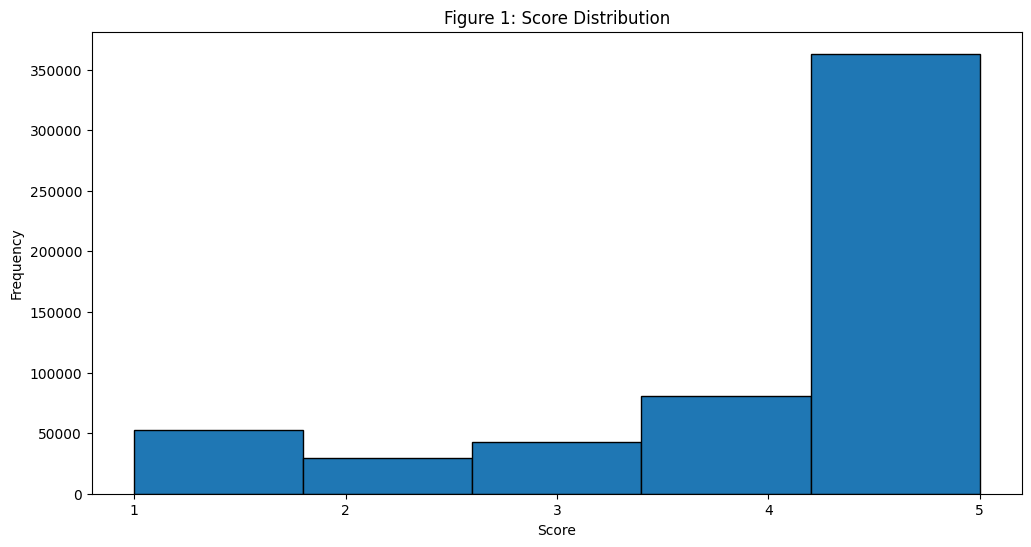

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the dataset
df = pd.read_csv('Data/Reviews.csv')

# Setting plot size
plt.figure(figsize=(12, 6))

# Plotting the histogram
plt.hist(df['Score'], bins=5, edgecolor='black')

# Set up the labels and axis
plt.title('Figure 1: Score Distribution') 
plt.xlabel('Score') 
plt.ylabel('Frequency')
plt.xticks(range(1, 6))

# Show the plot
plt.show()

Figure 1 shows that the distribution of the scores is not uniform, which will have to be taken into account during preprocessing. This means that when we are creating our labels, we must either remove samples from categories with higher frequencies or add samples to the categories with low frequencies. Given we have limited computational resources, the more reasonable approach is to reduce the size of the dataset rather than increase it.

Next, we visualize a word cloud of the text in the reviews. This will give us a general understanding of the text content of the reviews, as well as reveal any problematic patterns found in the text. This can be seen in figure 2.

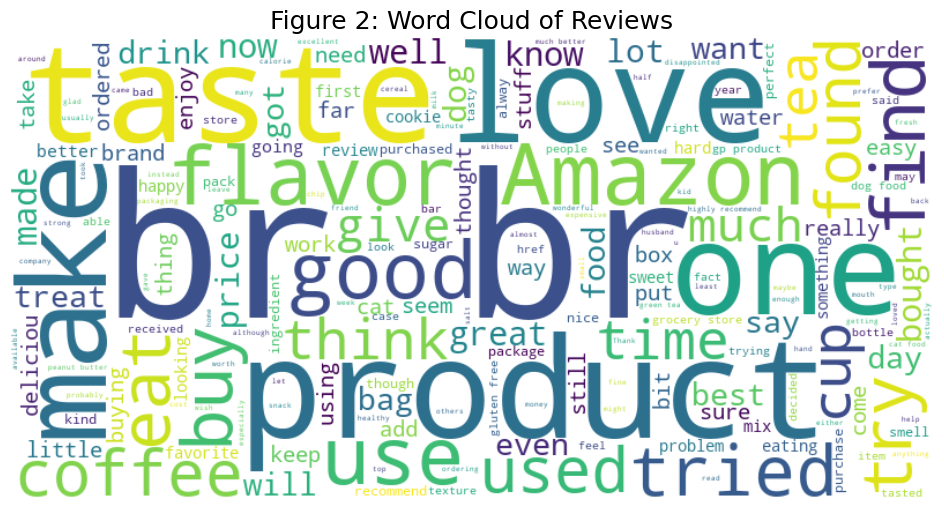

In [3]:
from wordcloud import WordCloud

# Word cloud for the text of the user reviews
text = ' '.join(df['Text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)


# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Plot the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')

# Set up axis and labels
plt.axis('off')
plt.title('Figure 2: Word Cloud of Reviews', fontsize = 18)

# Show the plot
plt.show()

Figure 2 immediatly reveals a problem with the text in our dataset, which is the existence of tags. This is the reason why "br" is written twice in such large letters. It also makes sense that words such as love, favourite, and treat are all included in this word cloud given the skewed distribution of the ratings. These two issues will be addressed in our data preprocessing.

Finally, Figure 3 shows the distribution of the lengths of the reviews in the dataset.

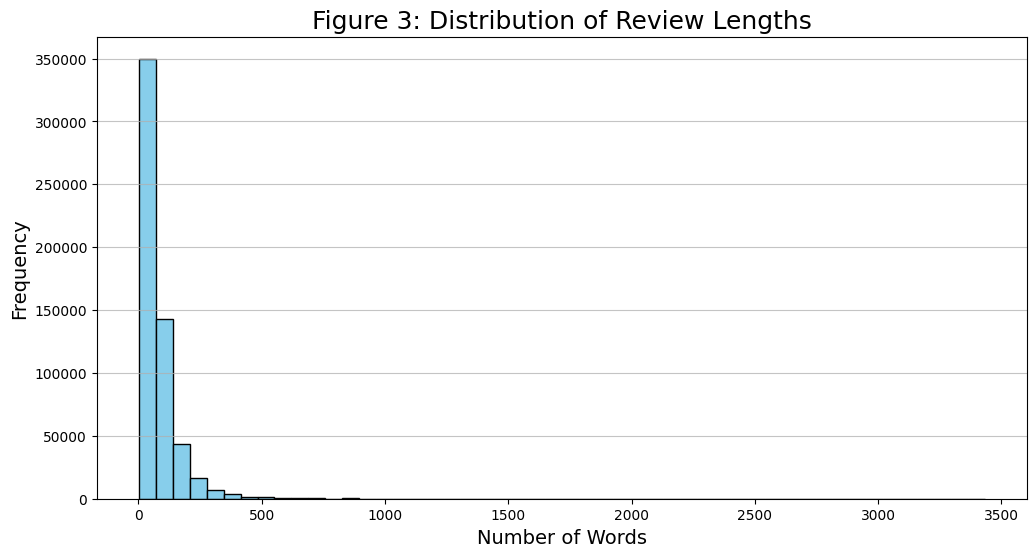

In [4]:
# Calculate the number of words in each review
df['ReviewLength'] = df['Text'].apply(lambda x: len(x.split()))

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the histogram
plt.hist(df['ReviewLength'], bins=50, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Figure 3: Distribution of Review Lengths', fontsize=18)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add grid lines for easier interpretation
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

Figure 3 shows that that the distribution of the lengths of reviews is heavily right skewed. Since the goal of the model is to gain insight into the sentiment of customers posting on social media posts which tend to be quite short (think YouTube comments or Tweets), it is reasonable to conclude that the lengths of the text is representitive of the content that the model will be used on. 

Though there are additional features included in the reviews dataset, the goal of this model is to categorize unstructured text from platforms such as Twitter and YouTube that do not contain information such as the helpfulness reviews or the product ID. Therefore, for the purposes of our model, we will only be using the text content of the reviews as the input for fine-tuning our model and the score for creating the labels.

### 5. Our Pipeline

##### 5.1 Data Preprocessing

The first step in the data pre-processing is to remove all the features that we will not be using for fine-tuning our model.

In [5]:
# Make a backup of the original dataframe
df_backup = df.copy()

# List of columns to keep
columns_to_keep = ['Text', 'Score']

# Drop all other columns
df_selected = df.drop(columns=[col for col in df.columns if col not in columns_to_keep])

# Display the first few rows to verify
print(df_selected.head())

   Score                                               Text
0      5  I have bought several of the Vitality canned d...
1      1  Product arrived labeled as Jumbo Salted Peanut...
2      4  This is a confection that has been around a fe...
3      2  If you are looking for the secret ingredient i...
4      5  Great taffy at a great price.  There was a wid...


Next, we want our model to predict whether a review is negative, neutral, or positive. To do this, we make a score of 1 or 2 represent a review with negative sentiment, a score of 3 represent a review with neutral sentiment, and a review of 4 or 5 to represent a review with positive sentiment.

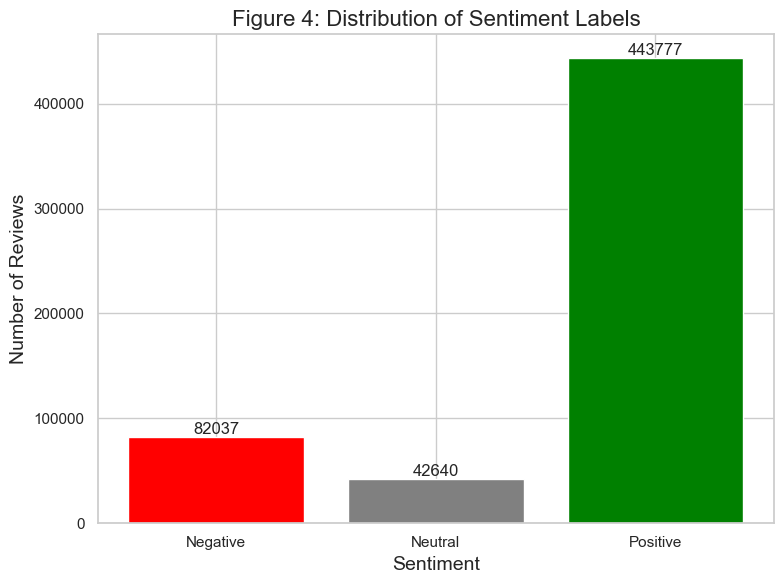

In [6]:
import seaborn as sns

# Function to map 'Score' to 'label' and create a bar chart of label distribution
def plot_sentiment_distribution(df, score_column='Score', label_column='label',title=str):
    """
    Maps the score to sentiment labels, creates the 'label' column, and plots a bar chart of sentiment distribution.

    Parameters:
    df (pd.DataFrame): The input dataset as a pandas DataFrame.
    score_column (str): The name of the column containing the score data.
    label_column (str): The name of the column to store the sentiment label data.

    Returns:
    None: Displays a bar chart showing the distribution of sentiment labels.
    """
    # Set the background of the plot to a white grid
    sns.set(style="whitegrid")

    # Define the mapping from Score to label
    score_to_label = {
        1: 0,  # Negative sentiment
        2: 0,  # Negative sentiment
        3: 1,  # Neutral sentiment
        4: 2,  # Positive sentiment
        5: 2   # Positive sentiment
    }

    # Map 'Score' to 'label' column
    df[label_column] = df[score_column].map(score_to_label)

    # Count the occurrences of each label
    label_counts = df[label_column].value_counts().sort_index()

    # Define label names for better readability
    label_names = ['Negative', 'Neutral', 'Positive']

    # Create the bar chart
    plt.figure(figsize=(8, 6))
    bars = plt.bar(label_names, label_counts, color=['red', 'gray', 'green'])

    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel('Sentiment', fontsize=14)
    plt.ylabel('Number of Reviews', fontsize=14)

    # Add count labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 5, 
                 f'{int(height)}', ha='center', va='bottom', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a DataFrame named df_selected with a 'Score' column
plot_sentiment_distribution(df_selected, score_column='Score', label_column='label',title='Figure 4: Distribution of Sentiment Labels')


Figure 4 shows the distribution of each label. This plot illustrates the already known issue that we do not have a uniform distribution of the different review sentiments. We fix this by randomly selecting 42,640 samples from the "Positive" sentiment class and the "Negative" sentiment class and dropping the other rows. This fixes two problems for us. The first is the already mentioned non-uniform distribution of the sentiments. If we show our model signficantly more reviews with positive sentiments as opposed to negative or neutral sentiments, the final model will perform poorly when classifying new reviews with neutral or negative sentiment. The second issue it resolves is it reduces the size of our very large dataset. Due to computational limitations, it would be infeasible to use all the data in the original dataset. 

/var/folders/yl/842rvw2j7mq5t40qz5hg61fh0000gn/T/ipykernel_56877/3387499048.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_selected.groupby('label').apply(


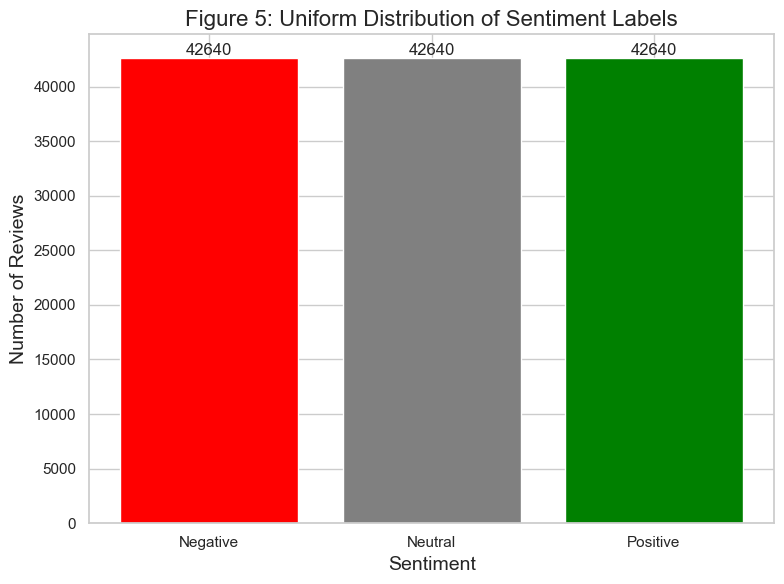

In [7]:
# Define the target number of samples per sentiment
target_count = 42640

# Set a random seed for reproducibility
random_state = 42

# Sample equal number of reviews for each sentiment
df_balanced = df_selected.groupby('label').apply(
    lambda x: x.sample(n=target_count, random_state=random_state)
).reset_index(drop=True)

# Shuffle the balanced DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

# Plot the Sentiment-Distribution
plot_sentiment_distribution(df_balanced, score_column='Score', label_column='label',title='Figure 5: Uniform Distribution of Sentiment Labels')

Now that the labels quantities in the dataset have a uniform distribution, the next step is to fix the issue of unwanted characters being included in the text.

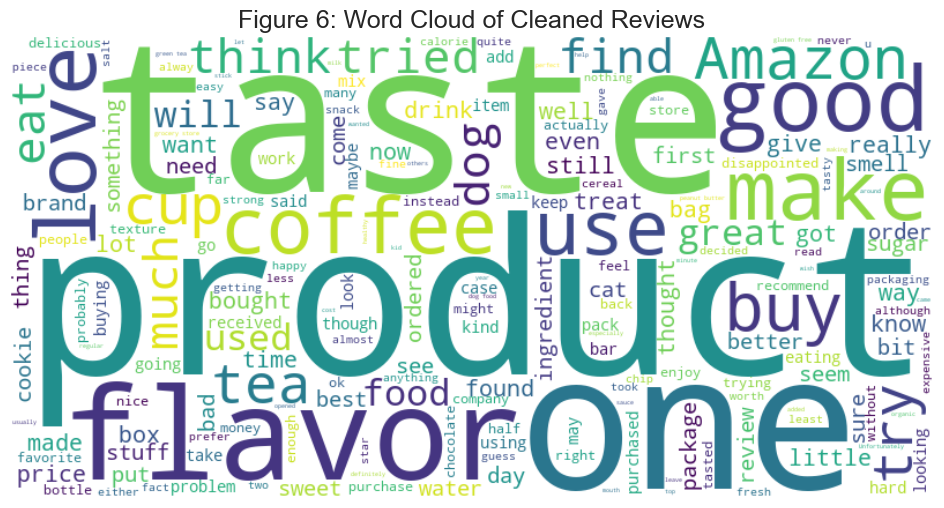

In [8]:
import re
# Define a function to clean text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply the cleaning function to the 'Text' column
df_balanced['Text'] = df_balanced['Text'].apply(clean_text)

# Create a word cloud to confirm adjustments of text worked correctly
text = ' '.join(df_balanced['Text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Plot the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')

# Set up axis and labels
plt.axis('off')
plt.title('Figure 6: Word Cloud of Cleaned Reviews', fontsize = 18)

# Show the plot
plt.show()

Figue 6 confirms that the desired changes to the dataset have been made. We now define the tokenizer that we will use for our model.

In [9]:
# Setting up the model and tokenizer
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer, TFRobertaModel

# Load the pre-trained tokenizer and sentiment fine-tuned model
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
model = TFRobertaForSequenceClassification.from_pretrained('distilroberta-base', output_hidden_states = True)

/opt/anaconda3/envs/venv_py311/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


The RoBERTa model that we will fine-tune has a maximum input length of 512 tokens. In this next step, we drop any rows that have more than 512 tokens to account for the fact that the RoBERTa model that we are using takes a maximum of 512 tokens. The results of this can be seen in Figure 6.

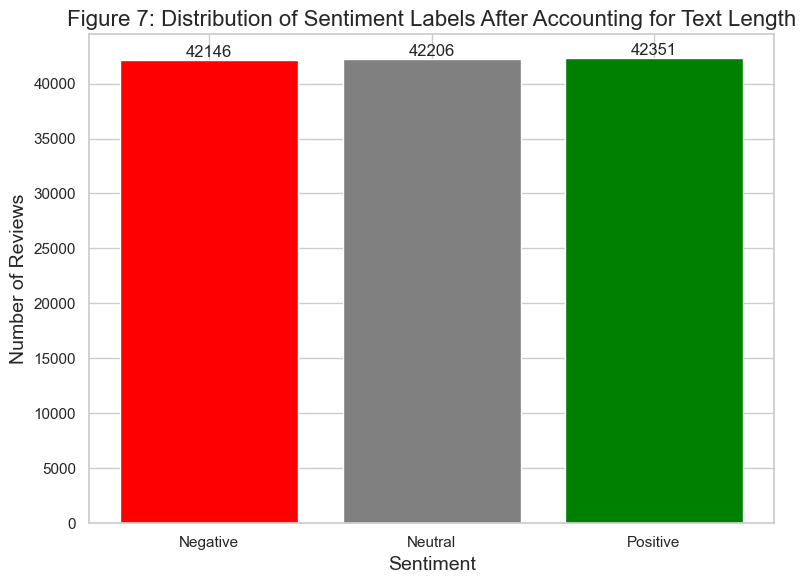

In [10]:
# Function to tokenize text without truncation (to check token length)
def count_tokens(text):
    tokens = tokenizer.encode(text, truncation=False)
    return len(tokens)

# Apply the token counting to the dataset
df_balanced['num_tokens'] = df_balanced['Text'].apply(count_tokens)

# Filter out rows where the token count exceeds max_length
max_length = 512
df_balanced_filtered = df_balanced[df_balanced['num_tokens'] <= max_length].reset_index(drop=True)

plot_sentiment_distribution(df_balanced_filtered, score_column='Score', label_column='label',title='Figure 7: Distribution of Sentiment Labels After Accounting for Text Length')

Figure 7 shows that this process had no negative effects on the distribution of sentiments. For the purpose's of training efficiency, we will work with a significantly smaller subset of the data so we can effecitvely experiemtn with the model. To do this, we will reduce each label to have 5000 rows. Once we have a model that starts seeing good performance, we will scale up the data to try to achieve maximum accuracy.

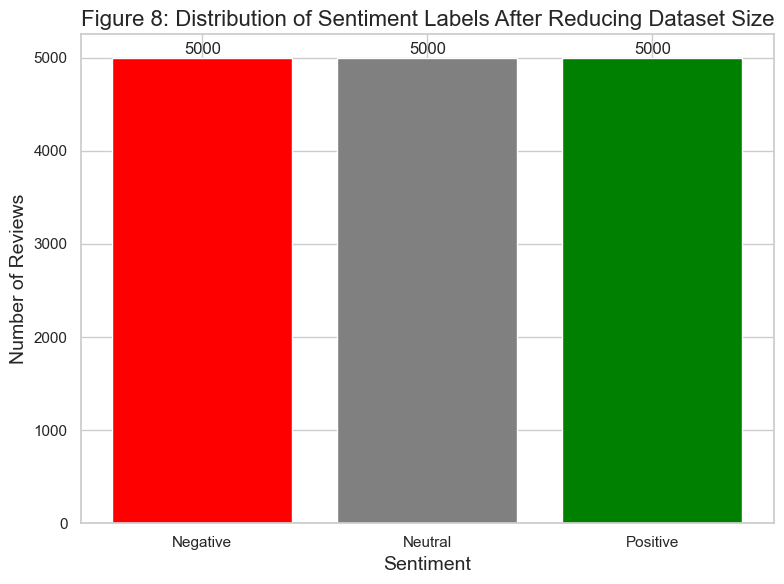

In [45]:
# Back up the full sized cleaned dataset
full_cleaned_df = df_balanced_filtered.copy()

experimenting_df = df_balanced_filtered.groupby('label').sample(n=5000, random_state=42).reset_index(drop=True)

plot_sentiment_distribution(experimenting_df, score_column='Score', label_column='label',title='Figure 8: Distribution of Sentiment Labels After Reducing Dataset Size')


 Next, we tokenize the text, split the data into training and testing sets, and convert the resulting data into Tensorflow datasets. 

In [ ]:
# Load the dataset
df = pd.read_csv('Data/Reviews.csv')

# Map 'Score' to sentiment labels
def map_score_to_label(score):
    if score in [1, 2]:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:  # 4 or 5
        return 2  # Positive

df['label'] = df['Score'].apply(map_score_to_label)

In [ ]:
# Balance the dataset by sampling 5000 reviews per class
df_balanced = df.groupby('label').apply(lambda x: x.sample(n=5000, random_state=42)).reset_index(drop=True)

# Clean the text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_balanced['cleaned_text'] = df_balanced['Text'].apply(clean_text)

In [ ]:
# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')

# Tokenize the text
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )

tokenized_texts = tokenize_function(df_balanced['cleaned_text'])

# Convert tensors to numpy arrays
input_ids = tokenized_texts['input_ids'].numpy()
attention_mask = tokenized_texts['attention_mask'].numpy()
labels = df_balanced['label'].values

# Clear unused variables to save memory
del tokenized_texts, df_balanced

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Split into train, validation, and test sets
train_input_ids, temp_input_ids, train_labels, temp_labels, train_attention_mask, temp_attention_mask = train_test_split(
    input_ids,
    labels,
    attention_mask,
    test_size=0.3,  # 70% train, 30% temp
    random_state=42
)

# Further split temp into validation and test sets
val_input_ids, test_input_ids, val_labels, test_labels, val_attention_mask, test_attention_mask = train_test_split(
    temp_input_ids,
    temp_labels,
    temp_attention_mask,
    test_size=0.5,  # 15% validation, 15% test
    random_state=42
)

# Clear unused variables to save memory
del input_ids, attention_mask, labels, temp_input_ids, temp_labels, temp_attention_mask

# Function to create TensorFlow datasets
def create_tf_dataset(input_ids, attention_mask, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': input_ids, 'attention_mask': attention_mask},
        labels
    ))
    dataset = dataset.batch(batch_size)
    return dataset

In [ ]:
import tensorflow as tf

# Build the model function
def build_model(base_model, activation_function='relu', dropout_rate=0.2, use_batchnorm=False, additional_layers=True):
    # Define inputs
    input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    # Get outputs from the base model
    outputs = base_model(input_ids, attention_mask=attention_mask)
    cls_token = outputs.last_hidden_state[:, 0, :]

    if additional_layers:
      # Add new encoding layers
      x = tf.keras.layers.Dense(512)(cls_token)
      if use_batchnorm:
          x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation(activation_function)(x)
      x = tf.keras.layers.Dropout(dropout_rate)(x)

      x = tf.keras.layers.Dense(256)(x)
      if use_batchnorm:
          x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation(activation_function)(x)
      x = tf.keras.layers.Dropout(dropout_rate)(x)

      x = tf.keras.layers.Dense(128)(x)
      if use_batchnorm:
          x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation(activation_function)(x)
      x = tf.keras.layers.Dropout(dropout_rate)(x)

      x = tf.keras.layers.Dense(64)(x)
      if use_batchnorm:
          x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation(activation_function)(x)
      x = tf.keras.layers.Dropout(dropout_rate)(x)

      output = tf.keras.layers.Dense(3, activation='softmax')(x)
    else:
      output = tf.keras.layers.Dense(3, activation='softmax')(cls_token)

    # Build the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return model

In [ ]:
# Function to get optimizer with specified learning rate
def get_optimizer(name, learning_rate):
    if name == 'adam':
        return tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif name == 'adamw':
        try:
            # For TensorFlow 2.11 and above
            return tf.keras.optimizers.experimental.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
        except AttributeError:
            # For earlier versions, use the experimental namespace
            return tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Fallback to Adam if AdamW is not available
    else:
        raise ValueError(f'Unsupported optimizer: {name}')

In [ ]:
import random
from sklearn.metrics import confusion_matrix, classification_report

# Define hyperparameter options
optimizers = ['adam', 'adamw']
learning_rates = [1e-5, 3e-5]
batch_sizes = [16, 32]
dropout_rates = [0.1, 0.2]
activation_functions = ['relu', 'tanh']
use_batchnorm_options = [True]

# Limit the number of configurations to manage computational resources
max_configs = 6 # Adjust this number based on your resources
configs = []

for _ in range(max_configs):
    config = {
        'optimizer': random.choice(optimizers),
        'learning_rate': random.choice(learning_rates),
        'batch_size': random.choice(batch_sizes),
        'dropout_rate': random.choice(dropout_rates),
        'activation_function': random.choice(activation_functions),
        'use_batchnorm': random.choice(use_batchnorm_options)
    }
    configs.append(config)

# Load the base RoBERTa model and freeze layers
base_model = TFRobertaModel.from_pretrained('distilroberta-base')
for layer in base_model.layers:
    layer.trainable = False

histories = []
results = []

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
def run_model(num_epochs, patience, configurations, base_model, additional_layers):

  # Initialize variables to keep track of the best model
  best_accuracy = 0
  best_model = None
  best_config = None
  best_y_pred = None

  # Loop over configurations
  for i, config in enumerate(configurations):
      print(f"Training configuration {i+1}/{len(configurations)}: {config}")

      # Build the model
      model = build_model(
          base_model,
          activation_function=config['activation_function'],
          dropout_rate=config['dropout_rate'],
          use_batchnorm=config['use_batchnorm'],
          additional_layers= additional_layers
      )

      # Get optimizer with specified learning rate
      optimizer = get_optimizer(config['optimizer'], learning_rate=config['learning_rate'])

      # Compile the model
      model.compile(
          optimizer=optimizer,
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      # Create datasets with specified batch size
      batch_size = config['batch_size']
      train_dataset = create_tf_dataset(train_input_ids, train_attention_mask, train_labels, batch_size)
      val_dataset = create_tf_dataset(val_input_ids, val_attention_mask, val_labels, batch_size)
      test_dataset = create_tf_dataset(test_input_ids, test_attention_mask, test_labels, batch_size)

      # Set up callbacks
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

      # Fit the model using the validation set
      history = model.fit(
          train_dataset,
          epochs=num_epochs,
          validation_data=val_dataset,
          callbacks=[early_stopping],
          verbose=1
      )

      # Record the history and config
      histories.append((history, config))

      # Evaluate the final model on the test set
      loss, accuracy = model.evaluate(test_dataset)
      print(f"Test accuracy: {accuracy}")

      # Store results
      results.append({
          'config': config,
          'accuracy': accuracy,
          'loss': loss,
      })

      # Generate predictions for the test set
      y_pred_probs = model.predict(test_dataset)
      y_pred = np.argmax(y_pred_probs, axis=1)

      # Flatten test labels
      y_true = test_labels

      # Compute confusion matrix
      cm = confusion_matrix(y_true, y_pred)

      # Classification report
      report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
      print(f"Classification Report for Configuration {i+1}:\n{report}")

      # Plot confusion matrix
      plt.figure(figsize=(6, 5))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
      plt.ylabel('Actual')
      plt.xlabel('Predicted')
      plt.title(f'Confusion Matrix for Configuration {i+1}')
      plt.show()

      # Store results
      results.append({
          'config': config,
          'accuracy': accuracy,
          'loss': loss,
          'confusion_matrix': cm,
          'classification_report': report
      })

      # If current model is better, save it
      if accuracy > best_accuracy:
          print("New best model found!")
          # Clear previous best model from memory if exists
          if best_model is not None:
              tf.keras.backend.clear_session()
              del best_model

          best_accuracy = accuracy
          best_model = model
          best_config = config
          best_y_pred = y_pred
          best_y_true = y_true
          # Also store confusion matrix and classification report
          best_cm = confusion_matrix(y_true, y_pred)
          best_report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
      else:
          # Clear current model from memory
          tf.keras.backend.clear_session()
          del model
  return best_accuracy, best_model, best_config, best_y_pred, best_y_true, best_cm, best_report

### 6. Training the Model

Below is the code that shows the training process for the first 6 models. After each model is trained, the confusion matrix is printed for the model, along with the combination of hyperparameters used to create it. The first set of 6 models was trained with batch normalization, the second set of 6 models was trained without batch normalization, and the final model was made by freezing only the first 3 encoding layers and unfreezing the 3 closest to the output layer.

#### 6.1 Batch-Normalized Models

##### 6.1.1 Batch-Normalized Models: Training

Training configuration 1/6: {'optimizer': 'adam', 'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.1, 'activation_function': 'relu', 'use_batchnorm': True}
Epoch 1/80
657/657 [==============================] - 81s 100ms/step - loss: 1.3414 - accuracy: 0.3602 - val_loss: 1.0844 - val_accuracy: 0.3964
Epoch 2/80
657/657 [==============================] - 63s 96ms/step - loss: 1.2345 - accuracy: 0.3923 - val_loss: 1.0120 - val_accuracy: 0.4631
Epoch 3/80
657/657 [==============================] - 63s 96ms/step - loss: 1.1664 - accuracy: 0.4189 - val_loss: 0.9703 - val_accuracy: 0.5213
Epoch 4/80
657/657 [==============================] - 64s 97ms/step - loss: 1.1236 - accuracy: 0.4438 - val_loss: 0.9312 - val_accuracy: 0.5707
Epoch 5/80
657/657 [==============================] - 66s 101ms/step - loss: 1.0794 - accuracy: 0.4653 - val_loss: 0.8963 - val_accuracy: 0.6018
Epoch 6/80
657/657 [==============================] - 64s 97ms/step - loss: 1.0318 - accuracy: 0.4993 - val_los

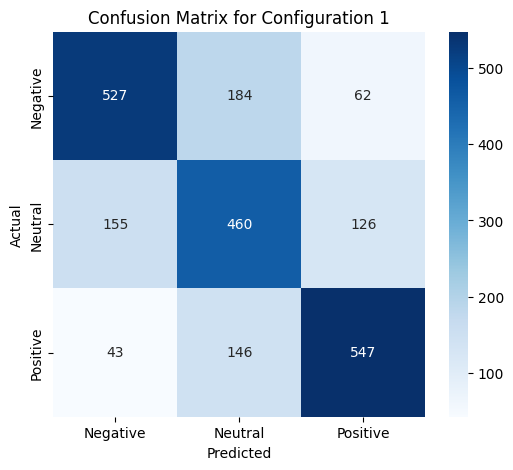

New best model found!
Training configuration 2/6: {'optimizer': 'adam', 'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.2, 'activation_function': 'relu', 'use_batchnorm': True}
Epoch 1/80
657/657 [==============================] - 75s 100ms/step - loss: 1.3088 - accuracy: 0.3475 - val_loss: 1.0889 - val_accuracy: 0.3671
Epoch 2/80
657/657 [==============================] - 64s 97ms/step - loss: 1.2587 - accuracy: 0.3684 - val_loss: 1.0649 - val_accuracy: 0.4169
Epoch 3/80
657/657 [==============================] - 64s 97ms/step - loss: 1.2111 - accuracy: 0.3794 - val_loss: 1.0413 - val_accuracy: 0.4684
Epoch 4/80
657/657 [==============================] - 63s 96ms/step - loss: 1.1946 - accuracy: 0.3920 - val_loss: 1.0249 - val_accuracy: 0.4893
Epoch 5/80
657/657 [==============================] - 64s 97ms/step - loss: 1.1591 - accuracy: 0.4123 - val_loss: 1.0072 - val_accuracy: 0.5036
Epoch 6/80
657/657 [==============================] - 63s 96ms/step - loss: 1.1359 - accur

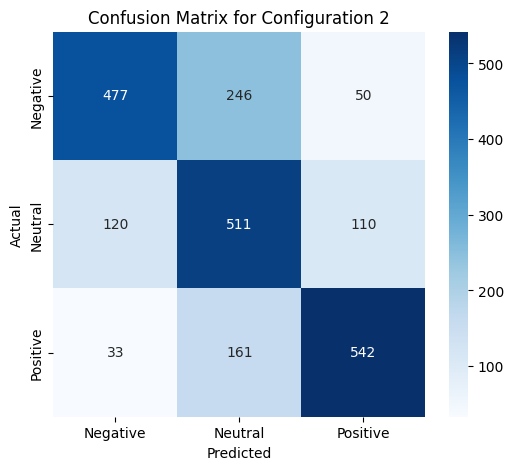

Training configuration 3/6: {'optimizer': 'adamw', 'learning_rate': 1e-05, 'batch_size': 32, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'use_batchnorm': True}
Epoch 1/80
329/329 [==============================] - 71s 186ms/step - loss: 1.1646 - accuracy: 0.4133 - val_loss: 0.9168 - val_accuracy: 0.5569
Epoch 2/80
329/329 [==============================] - 59s 181ms/step - loss: 1.0241 - accuracy: 0.4986 - val_loss: 0.8256 - val_accuracy: 0.6178
Epoch 3/80
329/329 [==============================] - 59s 179ms/step - loss: 0.9853 - accuracy: 0.5235 - val_loss: 0.7950 - val_accuracy: 0.6342
Epoch 4/80
329/329 [==============================] - 58s 177ms/step - loss: 0.9407 - accuracy: 0.5493 - val_loss: 0.7703 - val_accuracy: 0.6564
Epoch 5/80
329/329 [==============================] - 58s 177ms/step - loss: 0.9257 - accuracy: 0.5671 - val_loss: 0.7540 - val_accuracy: 0.6618
Epoch 6/80
329/329 [==============================] - 58s 176ms/step - loss: 0.9061 - accuracy: 0.5725 - va

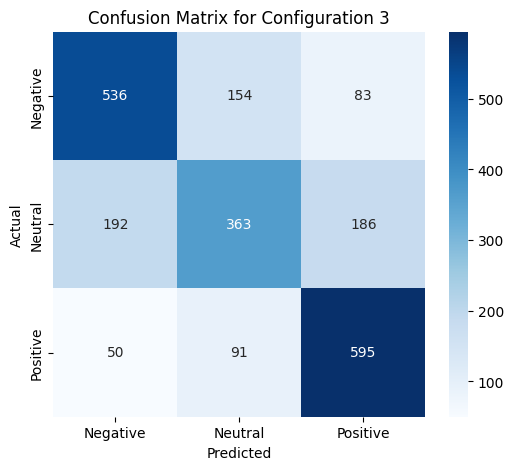

Training configuration 4/6: {'optimizer': 'adam', 'learning_rate': 3e-05, 'batch_size': 32, 'dropout_rate': 0.1, 'activation_function': 'relu', 'use_batchnorm': True}
Epoch 1/80
329/329 [==============================] - 69s 186ms/step - loss: 1.2325 - accuracy: 0.3845 - val_loss: 1.0759 - val_accuracy: 0.4009
Epoch 2/80
329/329 [==============================] - 58s 176ms/step - loss: 1.0995 - accuracy: 0.4637 - val_loss: 0.9677 - val_accuracy: 0.5240
Epoch 3/80
329/329 [==============================] - 58s 176ms/step - loss: 1.0272 - accuracy: 0.5068 - val_loss: 0.9125 - val_accuracy: 0.5609
Epoch 4/80
329/329 [==============================] - 58s 177ms/step - loss: 0.9839 - accuracy: 0.5324 - val_loss: 0.8582 - val_accuracy: 0.5884
Epoch 5/80
329/329 [==============================] - 59s 180ms/step - loss: 0.9542 - accuracy: 0.5526 - val_loss: 0.8174 - val_accuracy: 0.6218
Epoch 6/80
329/329 [==============================] - 59s 178ms/step - loss: 0.9307 - accuracy: 0.5630 - val

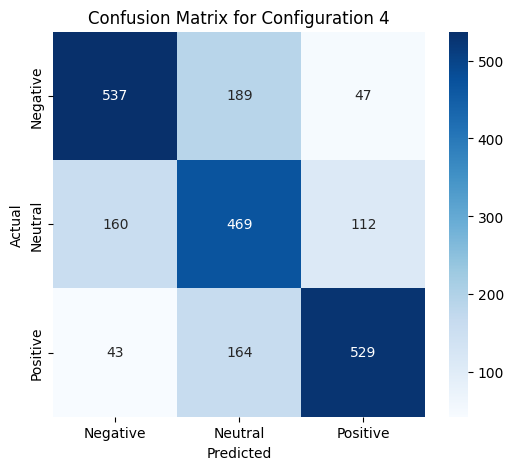

New best model found!
Training configuration 5/6: {'optimizer': 'adamw', 'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'use_batchnorm': True}
Epoch 1/80
657/657 [==============================] - 74s 100ms/step - loss: 1.1607 - accuracy: 0.4116 - val_loss: 0.8530 - val_accuracy: 0.6124
Epoch 2/80
657/657 [==============================] - 64s 98ms/step - loss: 1.0218 - accuracy: 0.5026 - val_loss: 0.7762 - val_accuracy: 0.6493
Epoch 3/80
657/657 [==============================] - 63s 96ms/step - loss: 0.9790 - accuracy: 0.5250 - val_loss: 0.7458 - val_accuracy: 0.6569
Epoch 4/80
657/657 [==============================] - 63s 96ms/step - loss: 0.9364 - accuracy: 0.5524 - val_loss: 0.7274 - val_accuracy: 0.6693
Epoch 5/80
657/657 [==============================] - 63s 97ms/step - loss: 0.9222 - accuracy: 0.5597 - val_loss: 0.7226 - val_accuracy: 0.6769
Epoch 6/80
657/657 [==============================] - 64s 97ms/step - loss: 0.9090 - accu

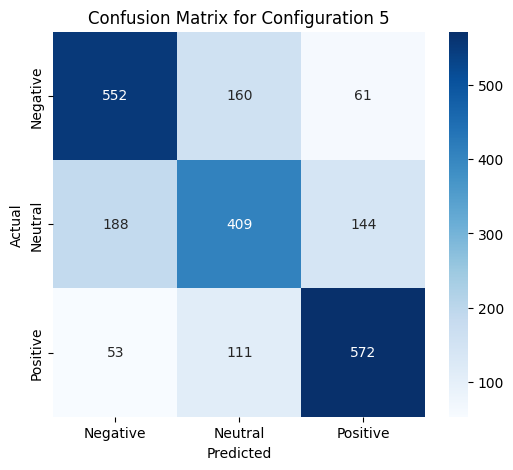

Training configuration 6/6: {'optimizer': 'adam', 'learning_rate': 3e-05, 'batch_size': 16, 'dropout_rate': 0.2, 'activation_function': 'relu', 'use_batchnorm': True}
Epoch 1/80
657/657 [==============================] - 74s 100ms/step - loss: 1.3482 - accuracy: 0.3550 - val_loss: 1.0332 - val_accuracy: 0.4782
Epoch 2/80
657/657 [==============================] - 64s 98ms/step - loss: 1.1878 - accuracy: 0.4230 - val_loss: 0.9304 - val_accuracy: 0.5756
Epoch 3/80
657/657 [==============================] - 64s 98ms/step - loss: 1.1114 - accuracy: 0.4662 - val_loss: 0.8691 - val_accuracy: 0.6076
Epoch 4/80
657/657 [==============================] - 63s 97ms/step - loss: 1.0518 - accuracy: 0.5013 - val_loss: 0.8196 - val_accuracy: 0.6378
Epoch 5/80
657/657 [==============================] - 64s 97ms/step - loss: 1.0183 - accuracy: 0.5194 - val_loss: 0.7807 - val_accuracy: 0.6600
Epoch 6/80
657/657 [==============================] - 64s 97ms/step - loss: 0.9804 - accuracy: 0.5428 - val_loss

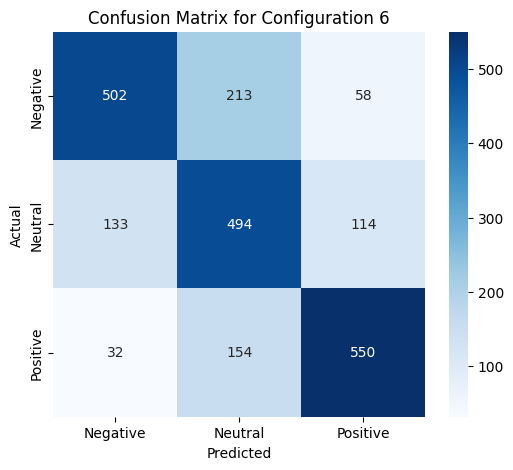

New best model found!


In [ ]:
# Run the model
best_accuracy, best_model, best_config, best_y_pred, best_y_true, best_cm, best_report = run_model(num_epochs=80, patience = 4, configurations= configs, base_model=base_model)

##### 6.1.2 Batch-Normalized Models: Examples of Mis-classified Points

In [ ]:
# After the training loop
print(f"\nBest Model Configuration: {best_config}")
print(f"Best Model Test Accuracy: {best_accuracy}")

# Use the best model's predictions
y_pred = best_y_pred
y_true = best_y_true

# Identify misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]

# Decode test texts
def decode_texts(input_ids):
    return [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

test_texts = decode_texts(test_input_ids)

# Extract false positives and false negatives
false_positives = []
false_negatives = []

# Mapping of label indices to label names
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Loop through misclassified examples to separate false positives and false negatives
for idx in misclassified_indices:
    true_label = y_true[idx]
    predicted_label = y_pred[idx]
    text = test_texts[idx]

    if predicted_label == 2 and true_label != 2:
        # Model predicted Positive, but true label is Negative or Neutral
        false_positives.append((text, label_map[true_label], label_map[predicted_label]))
    elif predicted_label != 2 and true_label == 2:
        # Model predicted Negative or Neutral, but true label is Positive
        false_negatives.append((text, label_map[true_label], label_map[predicted_label]))

# Display a few examples of false positives
print("\nExamples of False Positives:")
for i in range(min(3, len(false_positives))):
    text, true_label, predicted_label = false_positives[i]
    print(f"\nText: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")

# Display a few examples of false negatives
print("\nExamples of False Negatives:")
for i in range(min(3, len(false_negatives))):
    text, true_label, predicted_label = false_negatives[i]
    print(f"\nText: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")


Best Model Configuration: {'optimizer': 'adam', 'learning_rate': 3e-05, 'batch_size': 16, 'dropout_rate': 0.2, 'activation_function': 'relu', 'use_batchnorm': True}
Best Model Test Accuracy: 0.6871111392974854

Examples of False Positives:

Text: this is quite good ive taken to starting my mornings with a nice hot mug
True Label: Neutral
Predicted Label: Positive

Text: i love gloria jeans cinnamon nut strudel coffee and decided to try this the flavoring is a little over powering for me if youve tried this flavor before and like it you wont be disappointed with it in the kcups packaging
True Label: Neutral
Predicted Label: Positive

Text: we love clif kid z bars i decided to try these based on all of the great reviews we bought the strawberry and no one in the house likes them my kids are picky so i always try the treats just to see if they are even worth trying i eat healthy and dont mind most healthy snacks but even i did not care for these i am going to try another flavor but the s

In [ ]:
# Save the best model to a .keras file
best_model.save('best_model.keras')
print("\nBest model saved to 'best_model.keras'.")

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)



Best model saved to 'best_model.keras'.


##### 6.1.3 Batch-Normalized Models: Visualizations

We will show the process of training and plotting the training (not exactly sure what she means by this since the next section is to plot the validation set and analyze the behaviour of training and validation, but we'll figure it out).

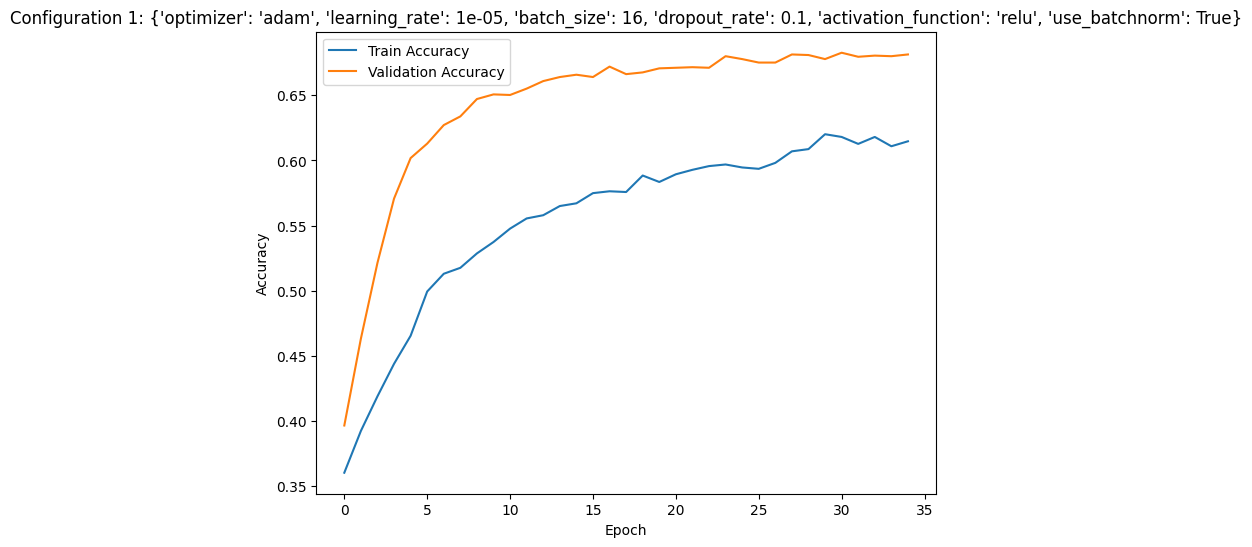

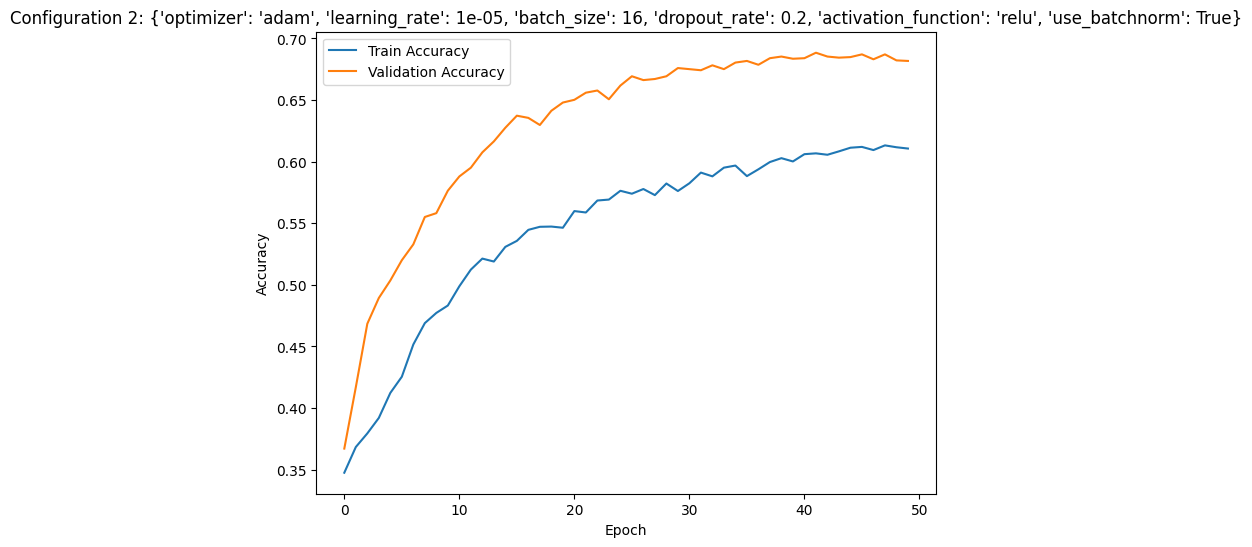

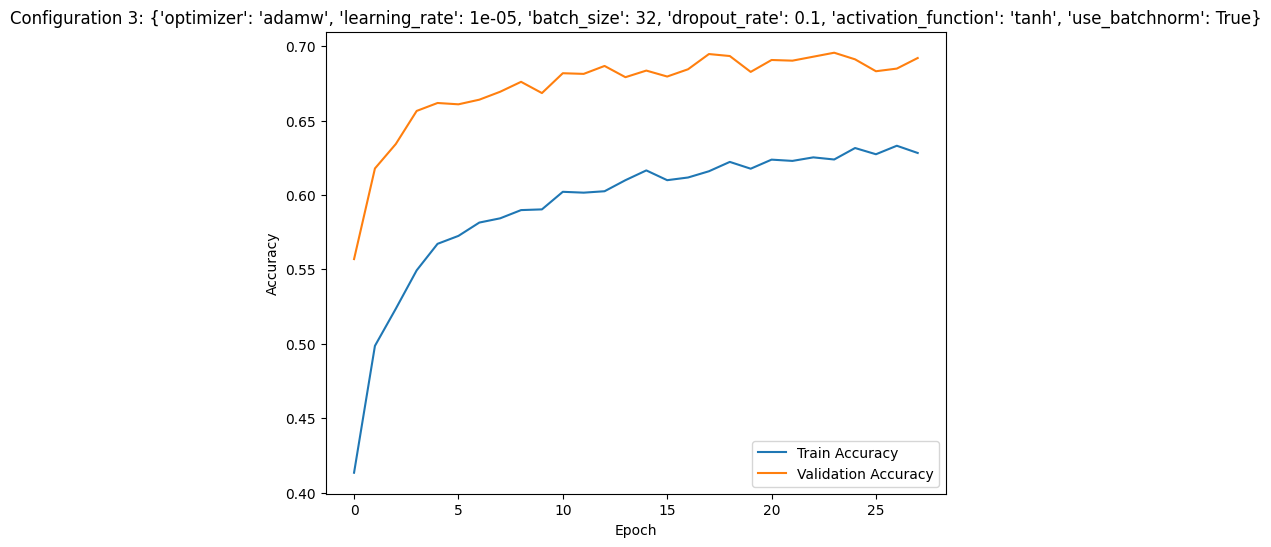

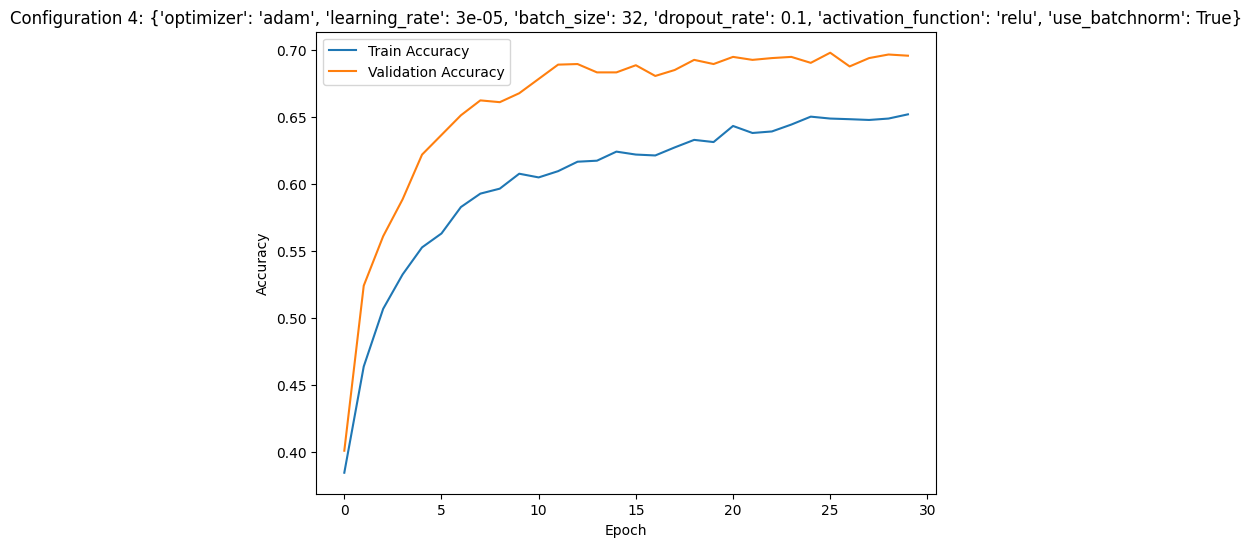

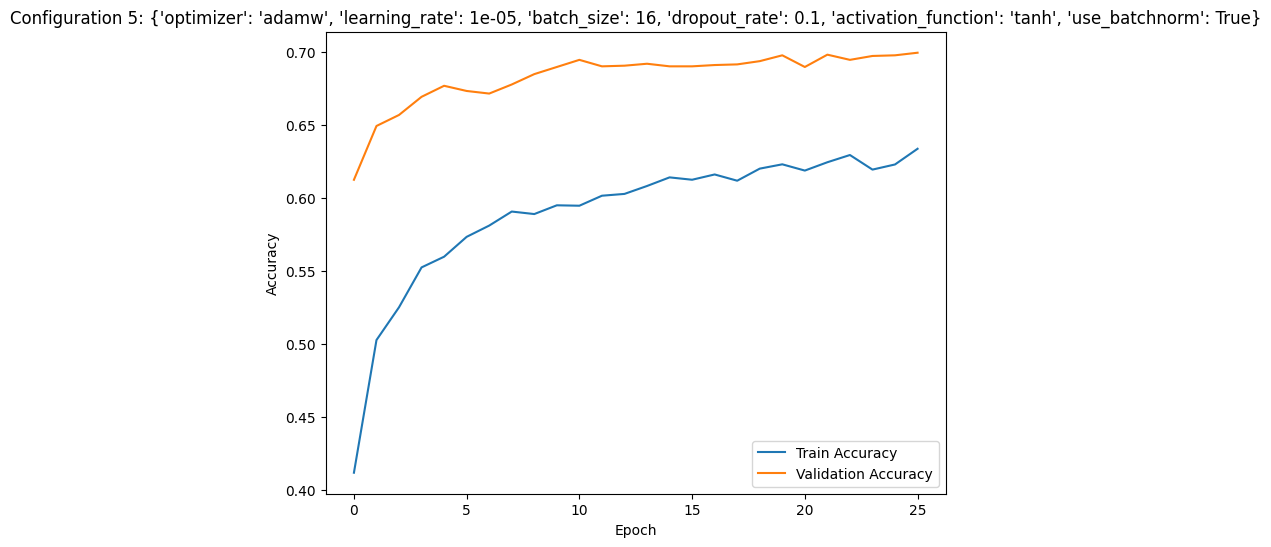

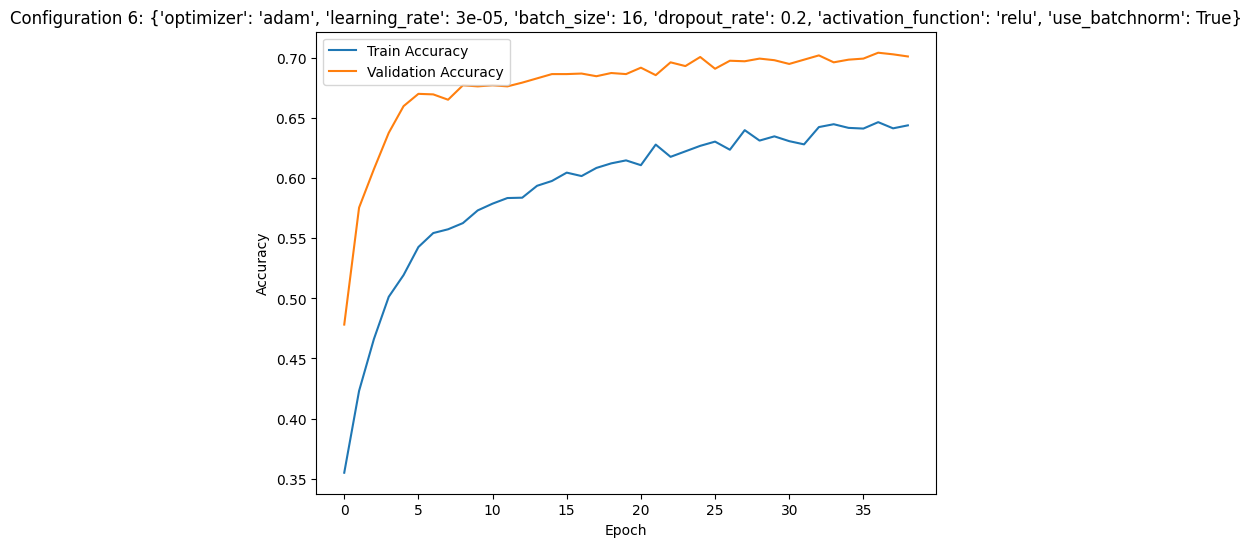

In [ ]:
# Visualize the results

# Plot training and validation accuracy for each configuration
for i, (history, config) in enumerate(histories):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Configuration {i+1}: {config}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


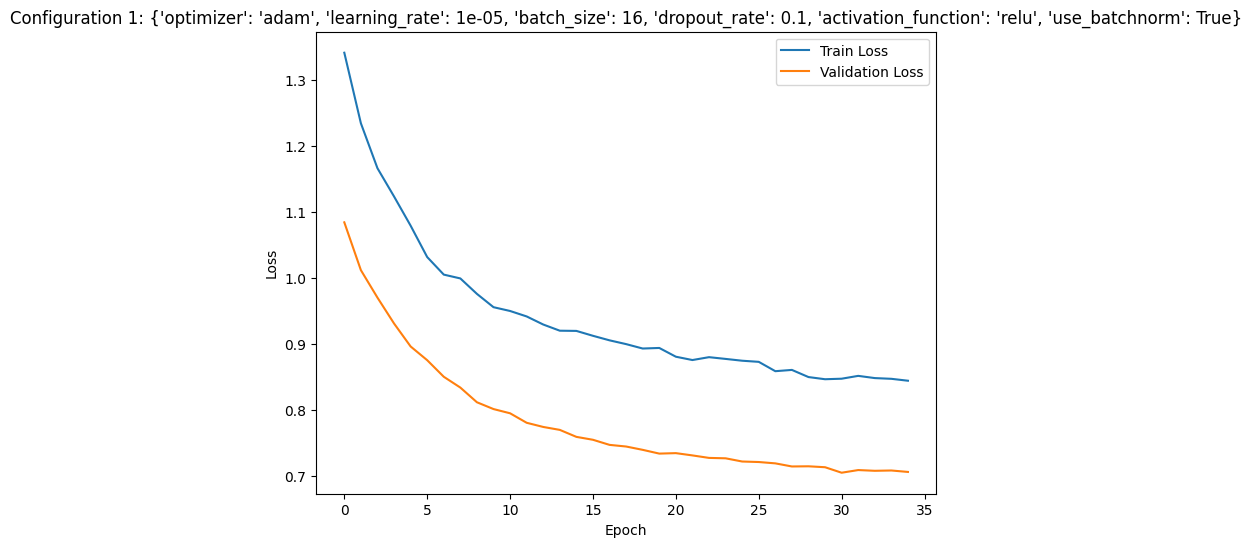

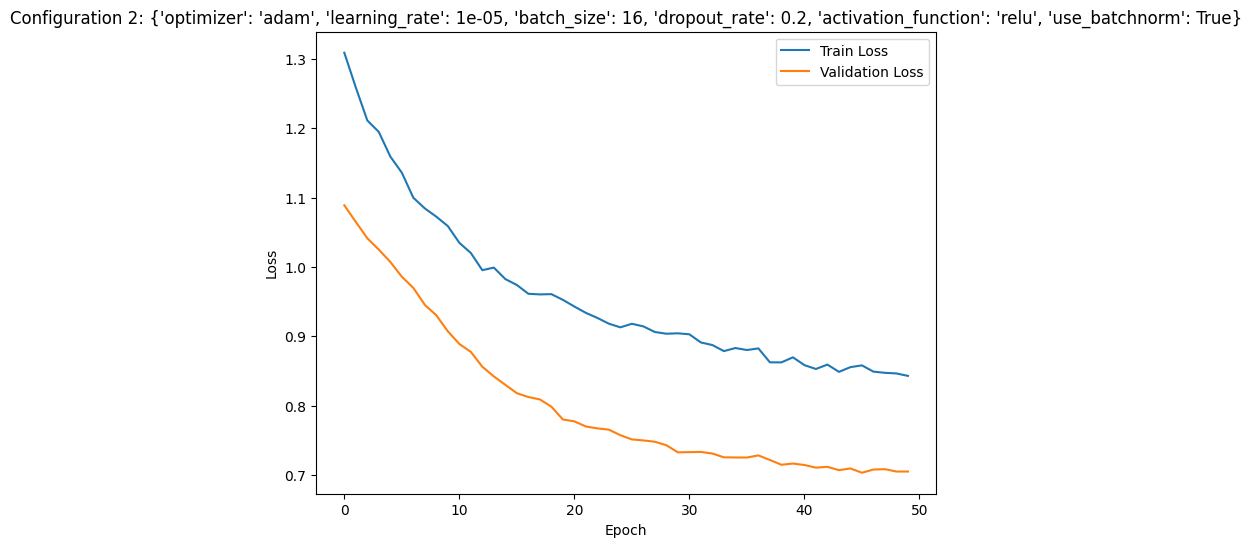

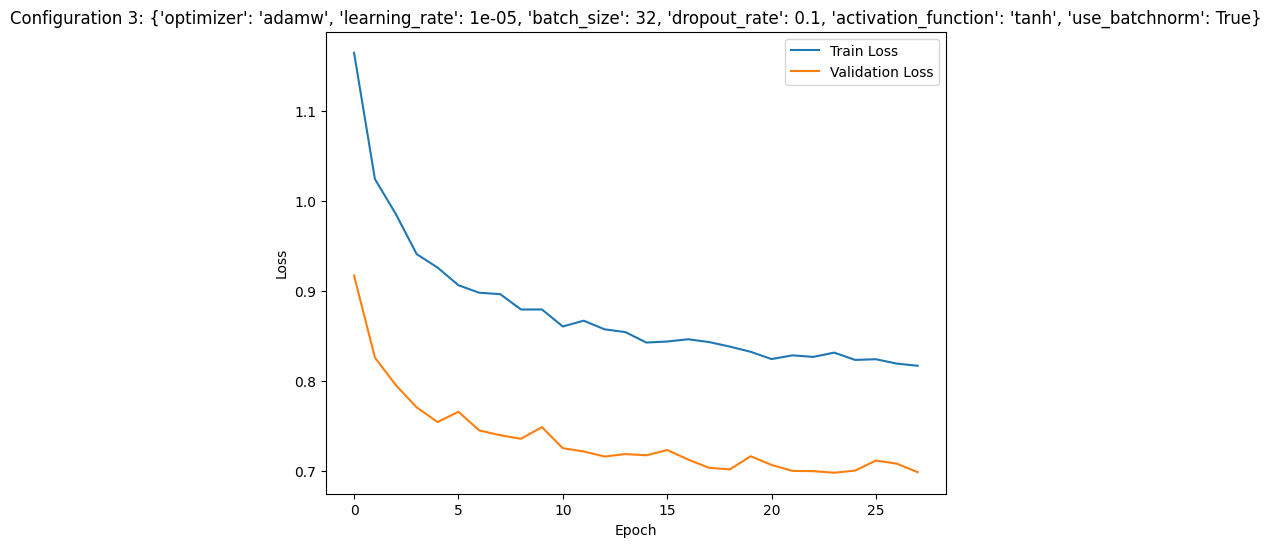

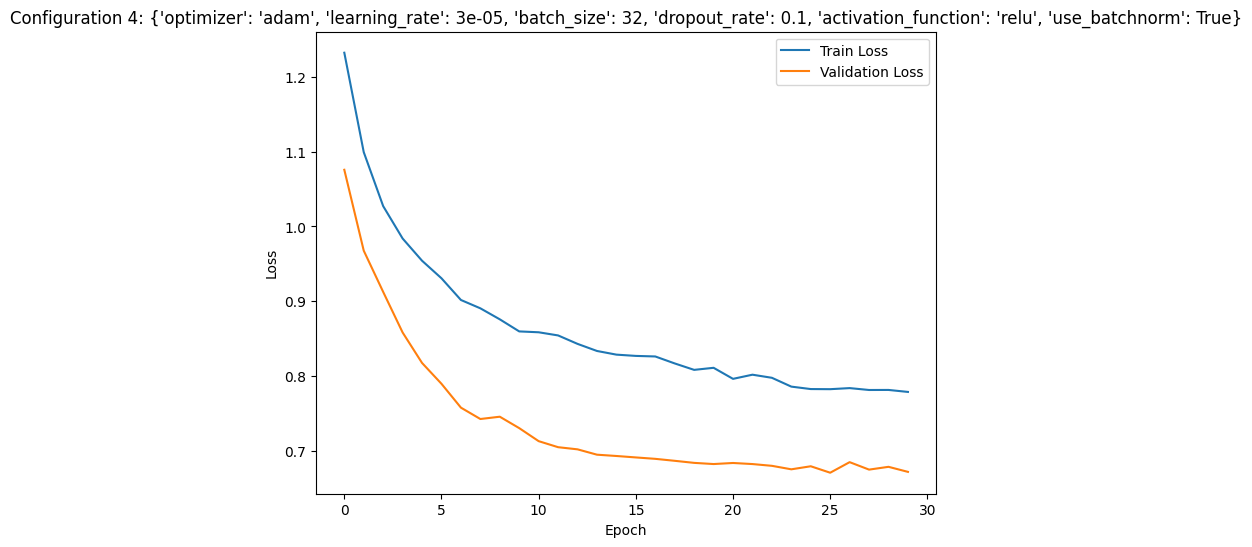

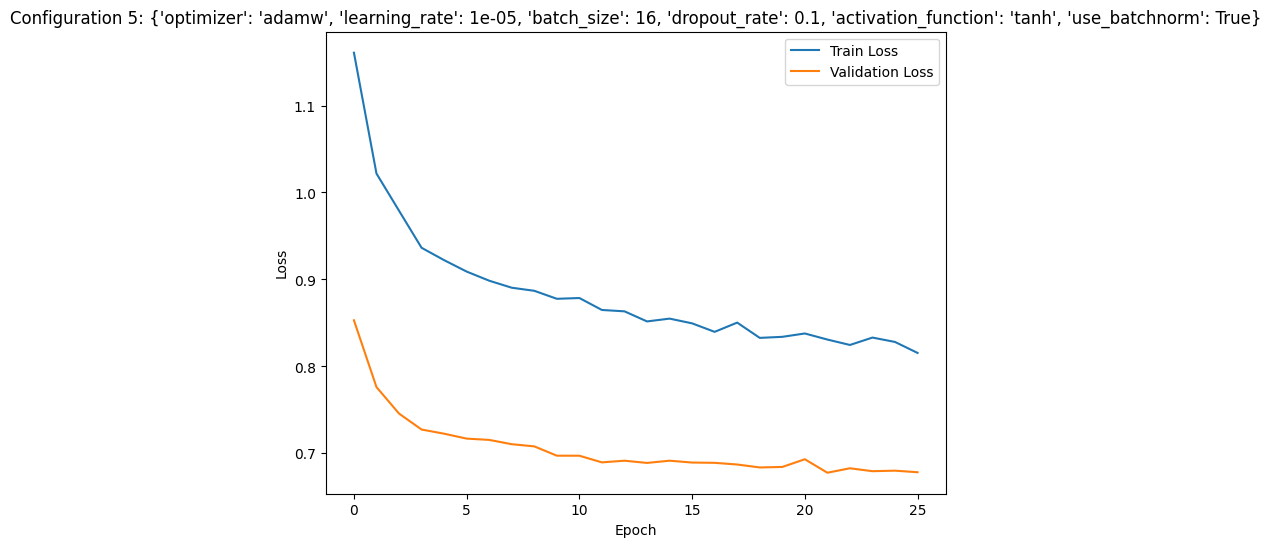

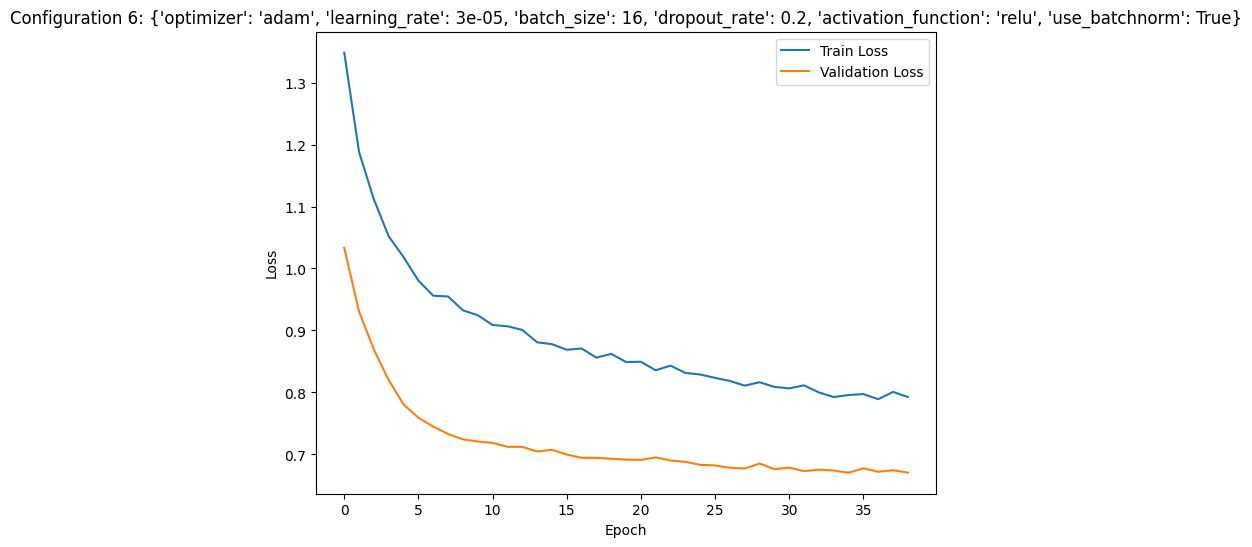

In [ ]:
# Plot training and validation loss for each configuration
for i, (history, config) in enumerate(histories):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Configuration {i+1}: {config}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

##### 6.1.4 Batch-Normalized Models: Table of Models

In [ ]:
# Create a DataFrame of the results
results_df = pd.DataFrame([{
    'optimizer': res['config']['optimizer'],
    'learning_rate': res['config']['learning_rate'],
    'batch_size': res['config']['batch_size'],
    'dropout_rate': res['config']['dropout_rate'],
    'activation_function': res['config']['activation_function'],
    'use_batchnorm': res['config']['use_batchnorm'],
    'accuracy': res['accuracy'],
    'loss': res['loss']
} for res in results])

print(results_df)

   optimizer  learning_rate  batch_size  dropout_rate activation_function  \
0       adam        0.00001          16           0.1                relu   
1       adam        0.00001          16           0.1                relu   
2       adam        0.00001          16           0.2                relu   
3       adam        0.00001          16           0.2                relu   
4      adamw        0.00001          32           0.1                tanh   
5      adamw        0.00001          32           0.1                tanh   
6       adam        0.00003          32           0.1                relu   
7       adam        0.00003          32           0.1                relu   
8      adamw        0.00001          16           0.1                tanh   
9      adamw        0.00001          16           0.1                tanh   
10      adam        0.00003          16           0.2                relu   
11      adam        0.00003          16           0.2                relu   

#### 6.2 Non-Batch-Normalized Models

##### 6.2.1 Non-Batch-Normalized Models: Training

In [ ]:
# Function to get optimizer with specified learning rate
def get_optimizer(name, learning_rate):
    if name == 'adam':
        return tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif name == 'adamw':
        try:
            # For TensorFlow 2.11 and above
            return tf.keras.optimizers.experimental.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
        except AttributeError:
            # For earlier versions, use the experimental namespace
            return tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Fallback to Adam if AdamW is not available
    else:
        raise ValueError(f'Unsupported optimizer: {name}')

In [ ]:
# Define hyperparameter options
optimizers = ['adam', 'adamw']
learning_rates = [1e-5, 3e-5]
batch_sizes = [16, 32]
dropout_rates = [0.1, 0.2]
activation_functions = ['relu', 'tanh']
use_batchnorm_options = [False] # prevent underfitting

# Limit the number of configurations to manage computational resources
max_configs = 6 # Adjust this number based on your resources
configs = []

for _ in range(max_configs):
    config = {
        'optimizer': random.choice(optimizers),
        'learning_rate': random.choice(learning_rates),
        'batch_size': random.choice(batch_sizes),
        'dropout_rate': random.choice(dropout_rates),
        'activation_function': random.choice(activation_functions),
        'use_batchnorm': random.choice(use_batchnorm_options)
    }
    configs.append(config)

# Load the base RoBERTa model and freeze layers
base_model = TFRobertaModel.from_pretrained('distilroberta-base')
for layer in base_model.layers:
    layer.trainable = False

histories = []
results = []

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
def run_model(num_epochs, patience, configurations, base_model, additional_layers):

  # Initialize variables to keep track of the best model
  best_accuracy = 0
  best_model = None
  best_config = None
  best_y_pred = None

  # Loop over configurations
  for i, config in enumerate(configurations):
      print(f"Training configuration {i+1}/{len(configurations)}: {config}")

      # Build the model
      model = build_model(
          base_model,
          activation_function=config['activation_function'],
          dropout_rate=config['dropout_rate'],
          use_batchnorm=config['use_batchnorm'],
          additional_layers= additional_layers
      )

      # Get optimizer with specified learning rate
      optimizer = get_optimizer(config['optimizer'], learning_rate=config['learning_rate'])

      # Compile the model
      model.compile(
          optimizer=optimizer,
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      # Create datasets with specified batch size
      batch_size = config['batch_size']
      train_dataset = create_tf_dataset(train_input_ids, train_attention_mask, train_labels, batch_size)
      val_dataset = create_tf_dataset(val_input_ids, val_attention_mask, val_labels, batch_size)
      test_dataset = create_tf_dataset(test_input_ids, test_attention_mask, test_labels, batch_size)

      # Set up callbacks
      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

      # Fit the model using the validation set
      history = model.fit(
          train_dataset,
          epochs=num_epochs,
          validation_data=val_dataset,
          callbacks=[early_stopping],
          verbose=1
      )

      # Record the history and config
      histories.append((history, config))

      # Evaluate the final model on the test set
      loss, accuracy = model.evaluate(test_dataset)
      print(f"Test accuracy: {accuracy}")

      # Store results
      results.append({
          'config': config,
          'accuracy': accuracy,
          'loss': loss,
      })

      # Generate predictions for the test set
      y_pred_probs = model.predict(test_dataset)
      y_pred = np.argmax(y_pred_probs, axis=1)

      # Flatten test labels
      y_true = test_labels

      # Compute confusion matrix
      cm = confusion_matrix(y_true, y_pred)

      # Classification report
      report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
      print(f"Classification Report for Configuration {i+1}:\n{report}")

      # Plot confusion matrix
      plt.figure(figsize=(6, 5))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
      plt.ylabel('Actual')
      plt.xlabel('Predicted')
      plt.title(f'Confusion Matrix for Configuration {i+1}')
      plt.show()

      # Store results
      results.append({
          'config': config,
          'accuracy': accuracy,
          'loss': loss,
          'confusion_matrix': cm,
          'classification_report': report
      })

      # If current model is better, save it
      if accuracy > best_accuracy:
          print("New best model found!")
          # Clear previous best model from memory if exists
          if best_model is not None:
              tf.keras.backend.clear_session()
              del best_model

          best_accuracy = accuracy
          best_model = model
          best_config = config
          best_y_pred = y_pred
          best_y_true = y_true
          # Also store confusion matrix and classification report
          best_cm = confusion_matrix(y_true, y_pred)
          best_report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
      else:
          # Clear current model from memory
          tf.keras.backend.clear_session()
          del model
  return best_accuracy, best_model, best_config, best_y_pred, best_y_true, best_cm, best_report

Training configuration 1/6: {'optimizer': 'adamw', 'learning_rate': 3e-05, 'batch_size': 16, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'use_batchnorm': False}
Epoch 1/80
657/657 [==============================] - 73s 101ms/step - loss: 1.0993 - accuracy: 0.3907 - val_loss: 0.9956 - val_accuracy: 0.5182
Epoch 2/80
657/657 [==============================] - 65s 99ms/step - loss: 0.9773 - accuracy: 0.5142 - val_loss: 0.8534 - val_accuracy: 0.6067
Epoch 3/80
657/657 [==============================] - 64s 98ms/step - loss: 0.8854 - accuracy: 0.5789 - val_loss: 0.7991 - val_accuracy: 0.6120
Epoch 4/80
657/657 [==============================] - 64s 98ms/step - loss: 0.8366 - accuracy: 0.6171 - val_loss: 0.7604 - val_accuracy: 0.6422
Epoch 5/80
657/657 [==============================] - 65s 98ms/step - loss: 0.8206 - accuracy: 0.6250 - val_loss: 0.7507 - val_accuracy: 0.6476
Epoch 6/80
657/657 [==============================] - 64s 98ms/step - loss: 0.8045 - accuracy: 0.6375 - val_lo

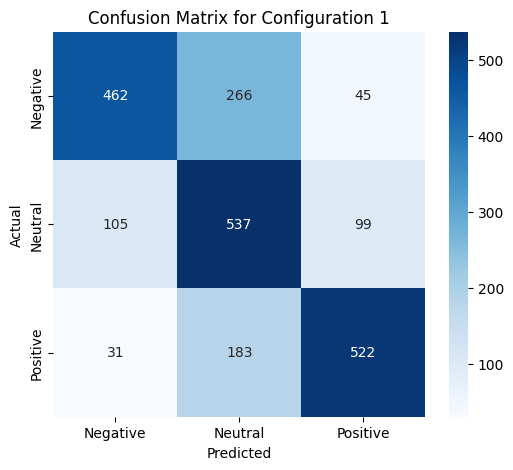

New best model found!
Training configuration 2/6: {'optimizer': 'adamw', 'learning_rate': 3e-05, 'batch_size': 32, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'use_batchnorm': False}
Epoch 1/80
329/329 [==============================] - 72s 194ms/step - loss: 1.1209 - accuracy: 0.3676 - val_loss: 1.0282 - val_accuracy: 0.5738
Epoch 2/80
329/329 [==============================] - 60s 184ms/step - loss: 1.0380 - accuracy: 0.4625 - val_loss: 0.9283 - val_accuracy: 0.5907
Epoch 3/80
329/329 [==============================] - 61s 186ms/step - loss: 0.9422 - accuracy: 0.5429 - val_loss: 0.8324 - val_accuracy: 0.6298
Epoch 4/80
329/329 [==============================] - 60s 182ms/step - loss: 0.8771 - accuracy: 0.5938 - val_loss: 0.7770 - val_accuracy: 0.6453
Epoch 5/80
329/329 [==============================] - 61s 184ms/step - loss: 0.8437 - accuracy: 0.6037 - val_loss: 0.7508 - val_accuracy: 0.6631
Epoch 6/80
329/329 [==============================] - 60s 183ms/step - loss: 0.8198 

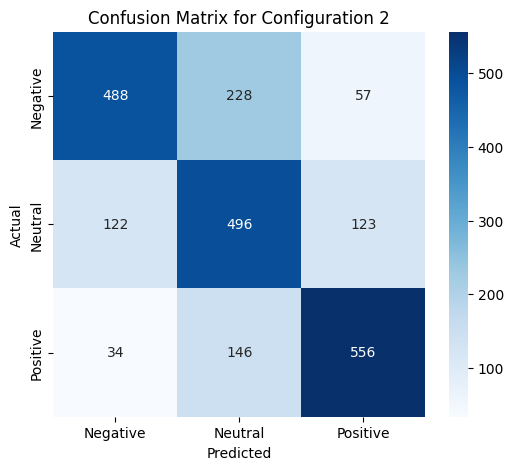

New best model found!
Training configuration 3/6: {'optimizer': 'adamw', 'learning_rate': 1e-05, 'batch_size': 32, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'use_batchnorm': False}
Epoch 1/80
329/329 [==============================] - 73s 193ms/step - loss: 1.1361 - accuracy: 0.3505 - val_loss: 1.0738 - val_accuracy: 0.4000
Epoch 2/80
329/329 [==============================] - 62s 187ms/step - loss: 1.1099 - accuracy: 0.3741 - val_loss: 1.0474 - val_accuracy: 0.5320
Epoch 3/80
329/329 [==============================] - 60s 183ms/step - loss: 1.0849 - accuracy: 0.4051 - val_loss: 1.0149 - val_accuracy: 0.5960
Epoch 4/80
329/329 [==============================] - 60s 183ms/step - loss: 1.0496 - accuracy: 0.4467 - val_loss: 0.9792 - val_accuracy: 0.6044
Epoch 5/80
329/329 [==============================] - 60s 184ms/step - loss: 1.0173 - accuracy: 0.4775 - val_loss: 0.9390 - val_accuracy: 0.6227
Epoch 6/80
329/329 [==============================] - 60s 184ms/step - loss: 0.9832 

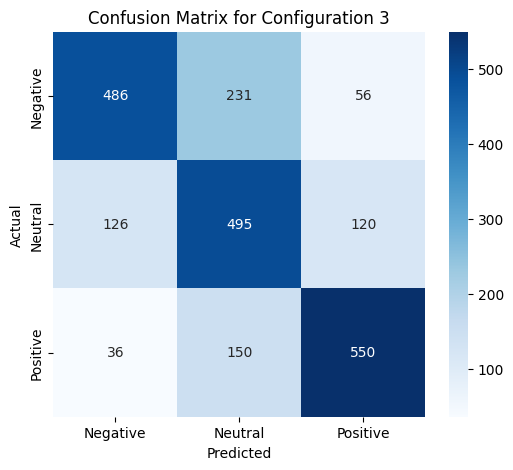

Training configuration 4/6: {'optimizer': 'adam', 'learning_rate': 3e-05, 'batch_size': 32, 'dropout_rate': 0.2, 'activation_function': 'relu', 'use_batchnorm': False}
Epoch 1/80
329/329 [==============================] - 69s 191ms/step - loss: 1.1155 - accuracy: 0.3318 - val_loss: 1.0964 - val_accuracy: 0.3342
Epoch 2/80
329/329 [==============================] - 60s 183ms/step - loss: 1.1025 - accuracy: 0.3490 - val_loss: 1.0937 - val_accuracy: 0.3324
Epoch 3/80
329/329 [==============================] - 62s 187ms/step - loss: 1.0987 - accuracy: 0.3498 - val_loss: 1.0883 - val_accuracy: 0.3840
Epoch 4/80
329/329 [==============================] - 60s 183ms/step - loss: 1.0907 - accuracy: 0.3711 - val_loss: 1.0680 - val_accuracy: 0.4951
Epoch 5/80
329/329 [==============================] - 61s 186ms/step - loss: 1.0743 - accuracy: 0.4113 - val_loss: 1.0329 - val_accuracy: 0.5276
Epoch 6/80
329/329 [==============================] - 60s 183ms/step - loss: 1.0440 - accuracy: 0.4538 - va

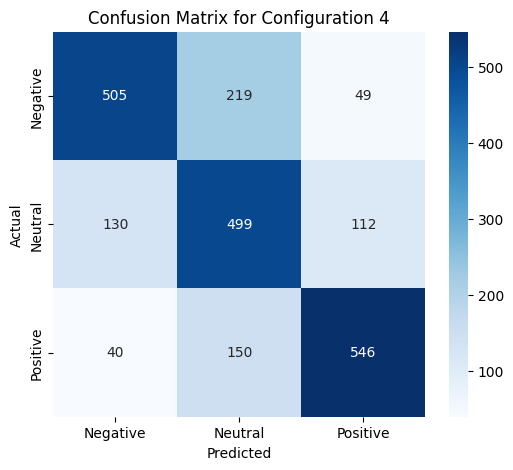

New best model found!
Training configuration 5/6: {'optimizer': 'adam', 'learning_rate': 1e-05, 'batch_size': 16, 'dropout_rate': 0.1, 'activation_function': 'tanh', 'use_batchnorm': False}
Epoch 1/80
657/657 [==============================] - 74s 102ms/step - loss: 1.1318 - accuracy: 0.3467 - val_loss: 1.0639 - val_accuracy: 0.4324
Epoch 2/80
657/657 [==============================] - 65s 99ms/step - loss: 1.0935 - accuracy: 0.3970 - val_loss: 1.0220 - val_accuracy: 0.5209
Epoch 3/80
657/657 [==============================] - 64s 98ms/step - loss: 1.0479 - accuracy: 0.4506 - val_loss: 0.9673 - val_accuracy: 0.6080
Epoch 4/80
657/657 [==============================] - 65s 98ms/step - loss: 1.0032 - accuracy: 0.4947 - val_loss: 0.9150 - val_accuracy: 0.6133
Epoch 5/80
657/657 [==============================] - 65s 99ms/step - loss: 0.9579 - accuracy: 0.5386 - val_loss: 0.8674 - val_accuracy: 0.6316
Epoch 6/80
657/657 [==============================] - 65s 98ms/step - loss: 0.9182 - accu

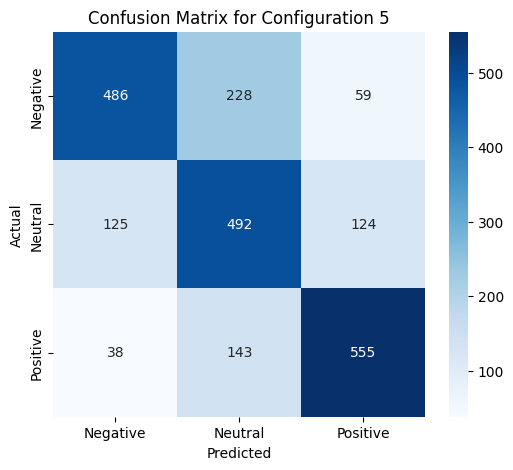

Training configuration 6/6: {'optimizer': 'adam', 'learning_rate': 3e-05, 'batch_size': 16, 'dropout_rate': 0.2, 'activation_function': 'relu', 'use_batchnorm': False}
Epoch 1/80
657/657 [==============================] - 74s 102ms/step - loss: 1.1243 - accuracy: 0.3430 - val_loss: 1.0926 - val_accuracy: 0.3338
Epoch 2/80
657/657 [==============================] - 65s 98ms/step - loss: 1.0952 - accuracy: 0.3697 - val_loss: 1.0708 - val_accuracy: 0.4542
Epoch 3/80
657/657 [==============================] - 65s 99ms/step - loss: 1.0765 - accuracy: 0.4084 - val_loss: 1.0314 - val_accuracy: 0.5991
Epoch 4/80
657/657 [==============================] - 65s 99ms/step - loss: 1.0347 - accuracy: 0.4702 - val_loss: 0.9296 - val_accuracy: 0.6027
Epoch 5/80
657/657 [==============================] - 65s 99ms/step - loss: 0.9706 - accuracy: 0.5165 - val_loss: 0.8441 - val_accuracy: 0.6142
Epoch 6/80
657/657 [==============================] - 65s 99ms/step - loss: 0.9237 - accuracy: 0.5471 - val_los

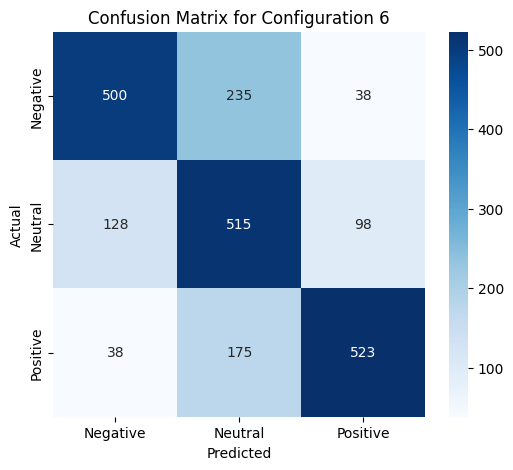

In [ ]:
# Run the model
best_accuracy, best_model, best_config, best_y_pred, best_y_true, best_cm, best_report = run_model(num_epochs=80, patience = 4, configurations= configs, base_model=base_model, additional_layers = True)

##### 6.2.2 Non-Batch-Normalized Models: Examples of Mis-classified Points

In [ ]:
# After the training loop
print(f"\nBest Model Configuration: {best_config}")
print(f"Best Model Test Accuracy: {best_accuracy}")

# Use the best model's predictions
y_pred = best_y_pred
y_true = best_y_true

# Identify misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]

# Decode test texts
def decode_texts(input_ids):
    return [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

test_texts = decode_texts(test_input_ids)

# Extract false positives and false negatives
false_positives = []
false_negatives = []

# Mapping of label indices to label names
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Loop through misclassified examples to separate false positives and false negatives
for idx in misclassified_indices:
    true_label = y_true[idx]
    predicted_label = y_pred[idx]
    text = test_texts[idx]

    if predicted_label == 2 and true_label != 2:
        # Model predicted Positive, but true label is Negative or Neutral
        false_positives.append((text, label_map[true_label], label_map[predicted_label]))
    elif predicted_label != 2 and true_label == 2:
        # Model predicted Negative or Neutral, but true label is Positive
        false_negatives.append((text, label_map[true_label], label_map[predicted_label]))

# Display a few examples of false positives
print("\nExamples of False Positives:")
for i in range(min(3, len(false_positives))):
    text, true_label, predicted_label = false_positives[i]
    print(f"\nText: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")

# Display a few examples of false negatives
print("\nExamples of False Negatives:")
for i in range(min(3, len(false_negatives))):
    text, true_label, predicted_label = false_negatives[i]
    print(f"\nText: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")


Best Model Configuration: {'optimizer': 'adam', 'learning_rate': 3e-05, 'batch_size': 32, 'dropout_rate': 0.2, 'activation_function': 'relu', 'use_batchnorm': False}
Best Model Test Accuracy: 0.6888889074325562

Examples of False Positives:

Text: this is quite good ive taken to starting my mornings with a nice hot mug
True Label: Neutral
Predicted Label: Positive

Text: i love gloria jeans cinnamon nut strudel coffee and decided to try this the flavoring is a little over powering for me if youve tried this flavor before and like it you wont be disappointed with it in the kcups packaging
True Label: Neutral
Predicted Label: Positive

Text: we love clif kid z bars i decided to try these based on all of the great reviews we bought the strawberry and no one in the house likes them my kids are picky so i always try the treats just to see if they are even worth trying i eat healthy and dont mind most healthy snacks but even i did not care for these i am going to try another flavor but the 

##### 6.2.3 Non-Batch-Normalized Models: Visualizations

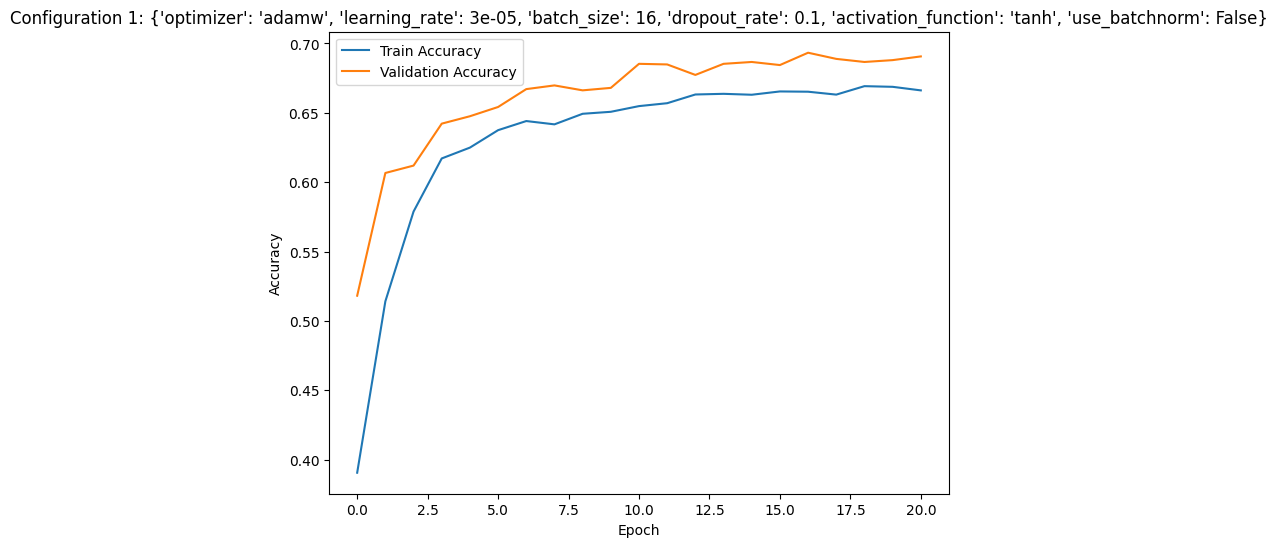

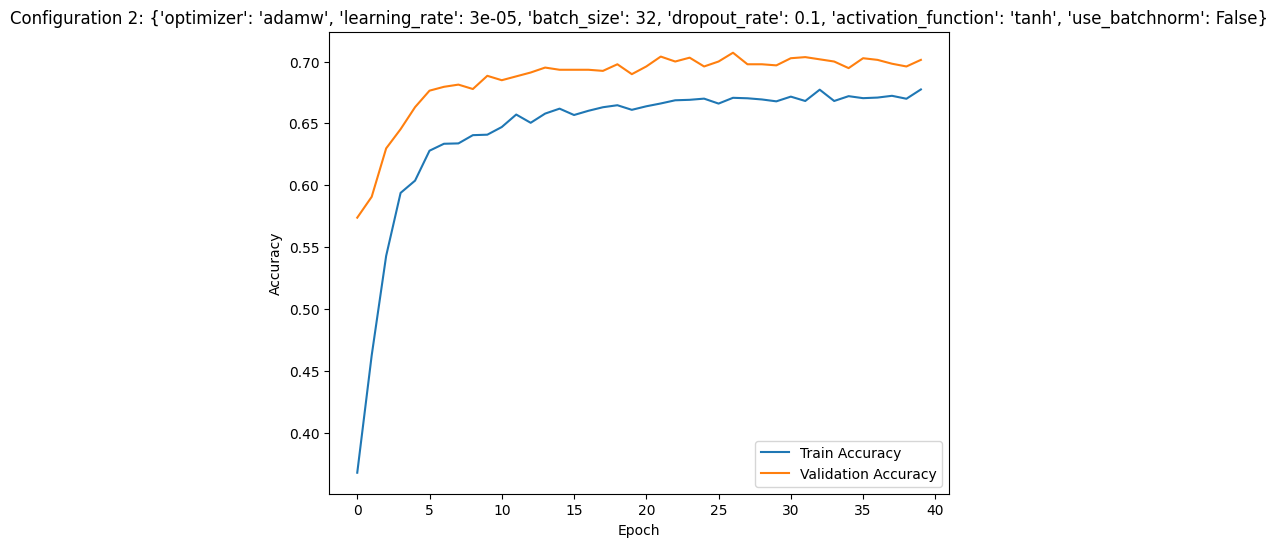

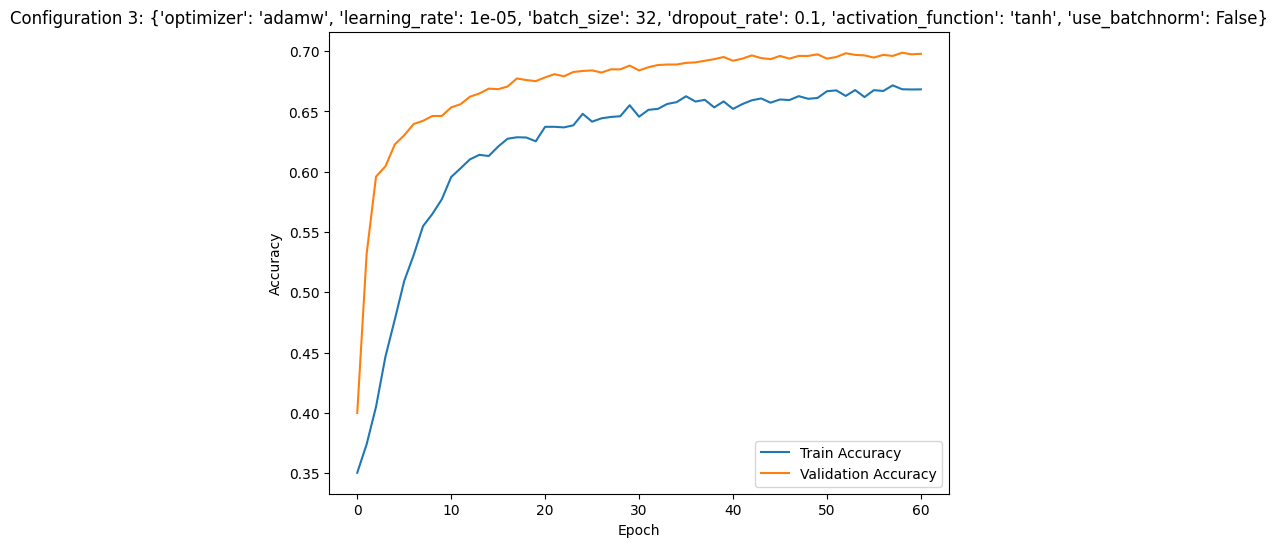

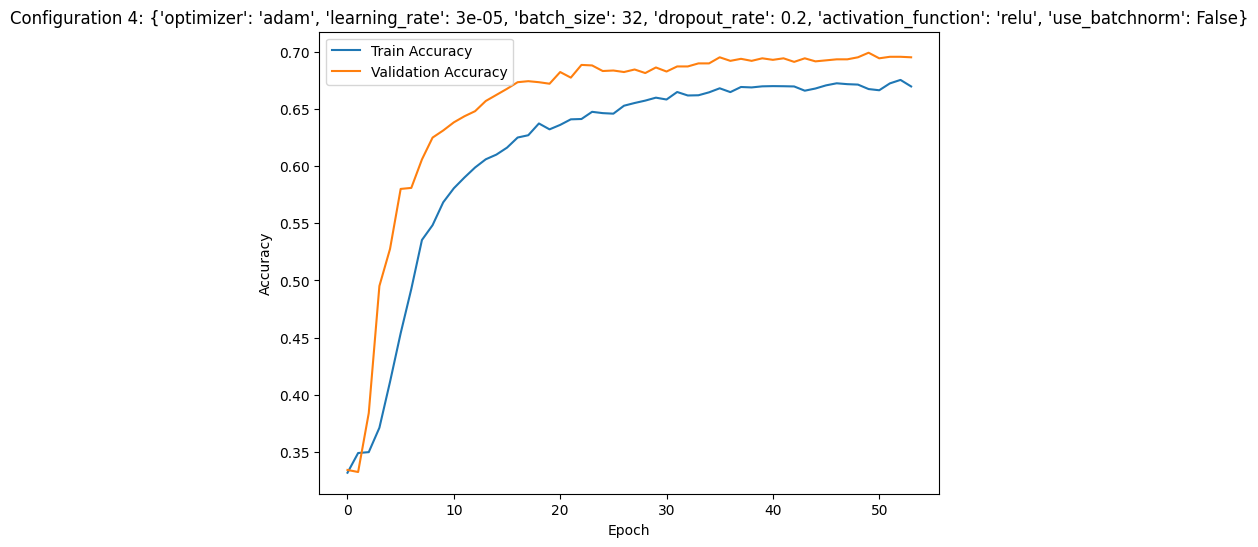

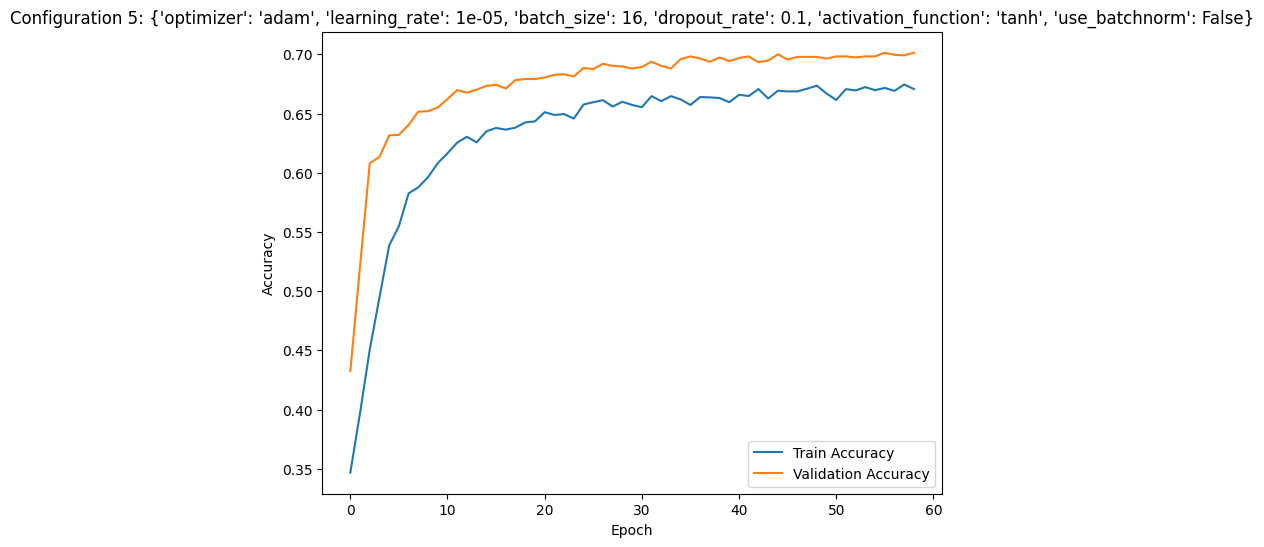

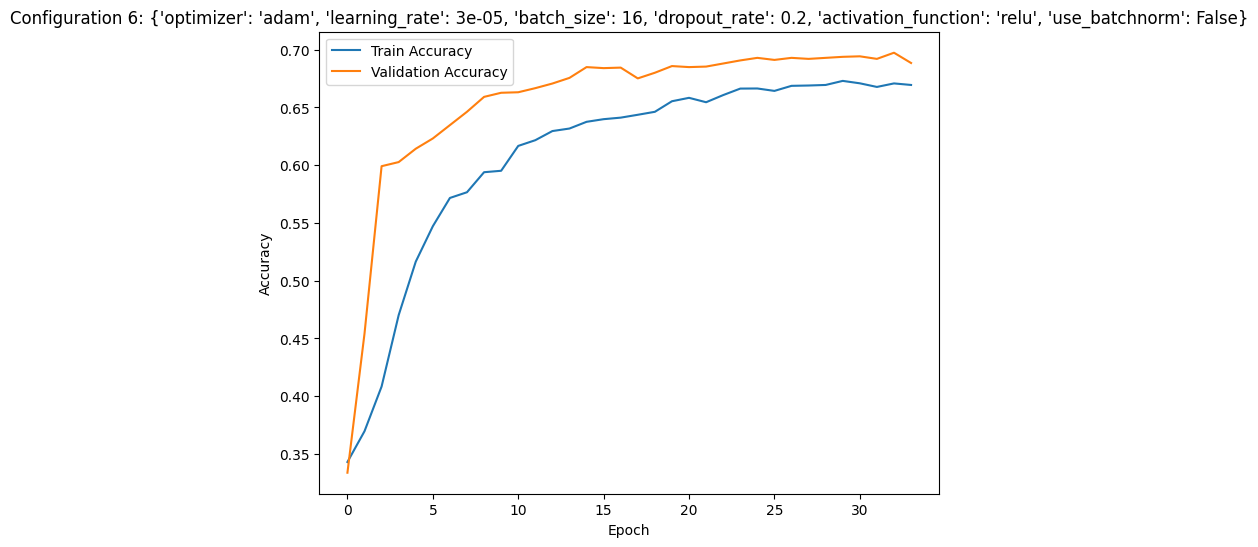

In [ ]:
# Visualize the results

# Plot training and validation accuracy for each configuration
for i, (history, config) in enumerate(histories):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Configuration {i+1}: {config}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


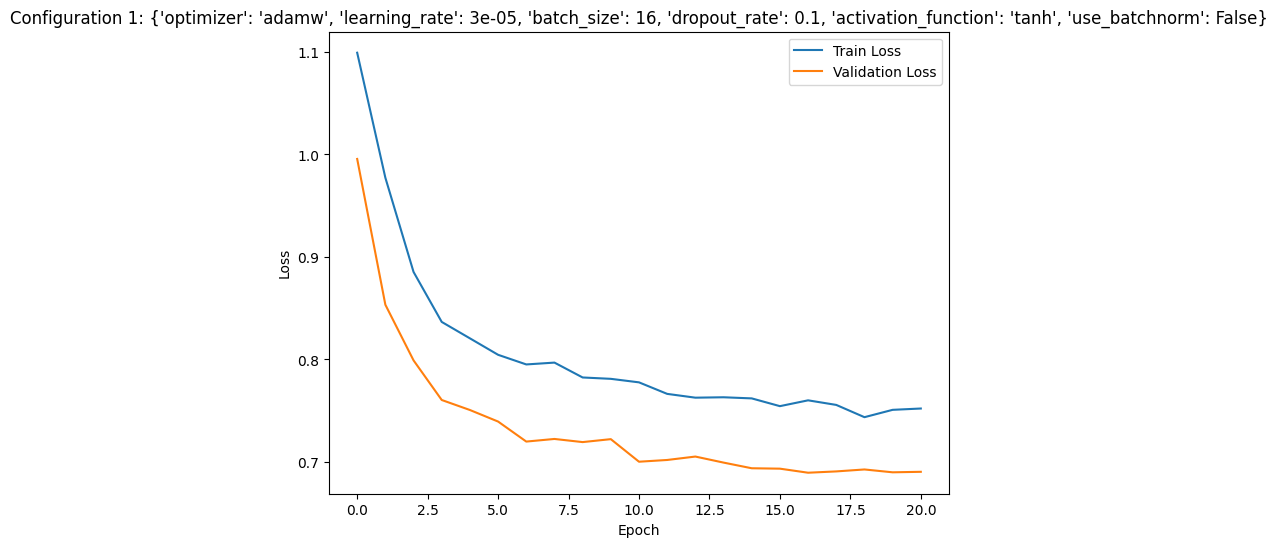

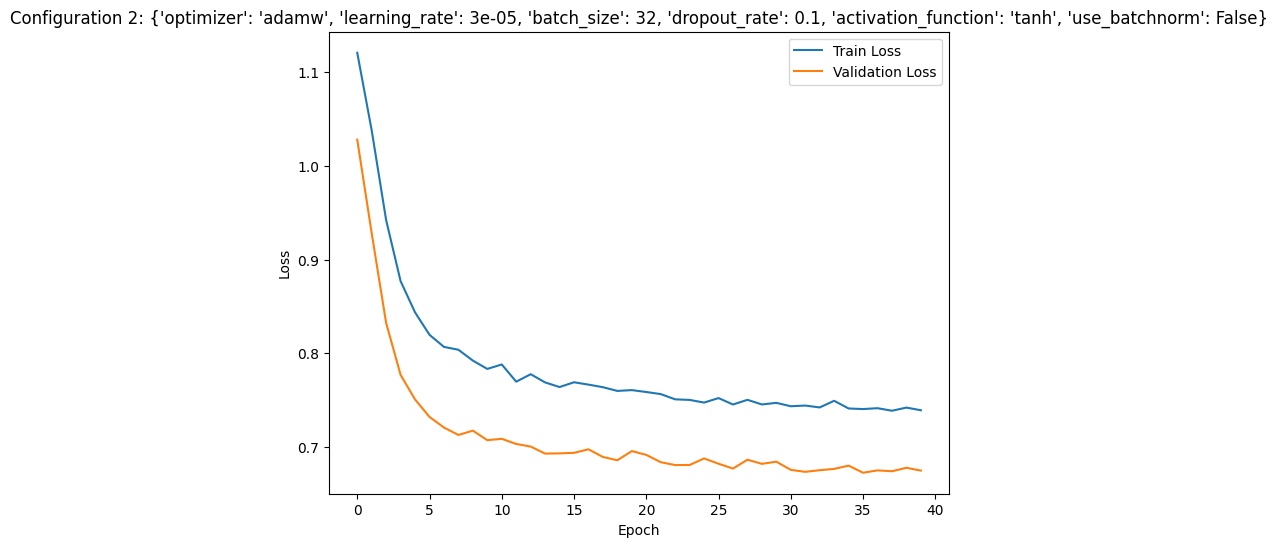

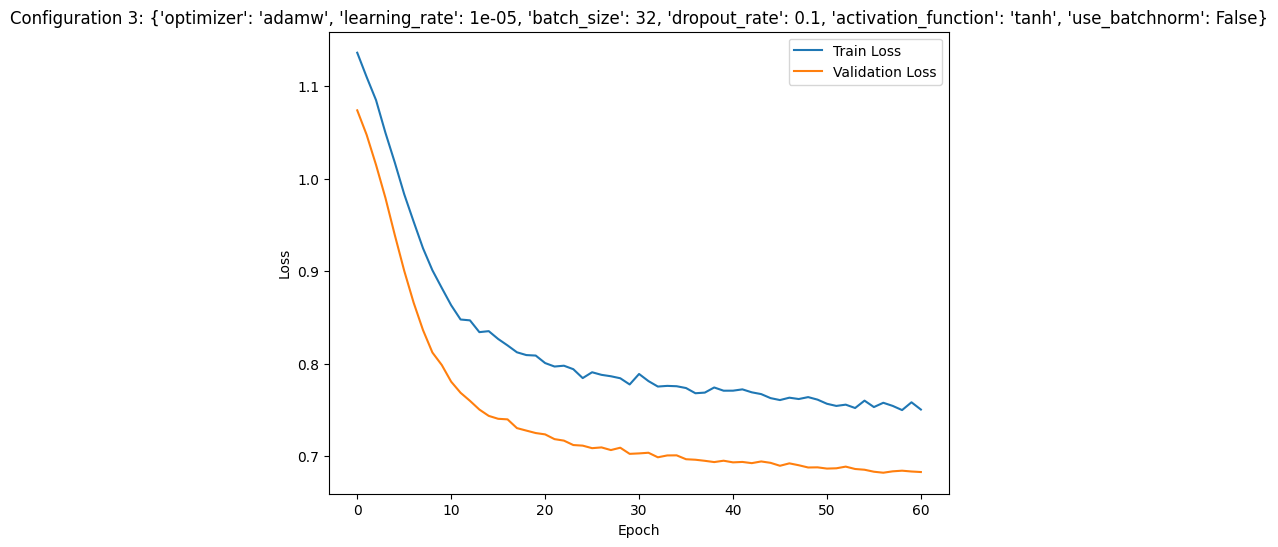

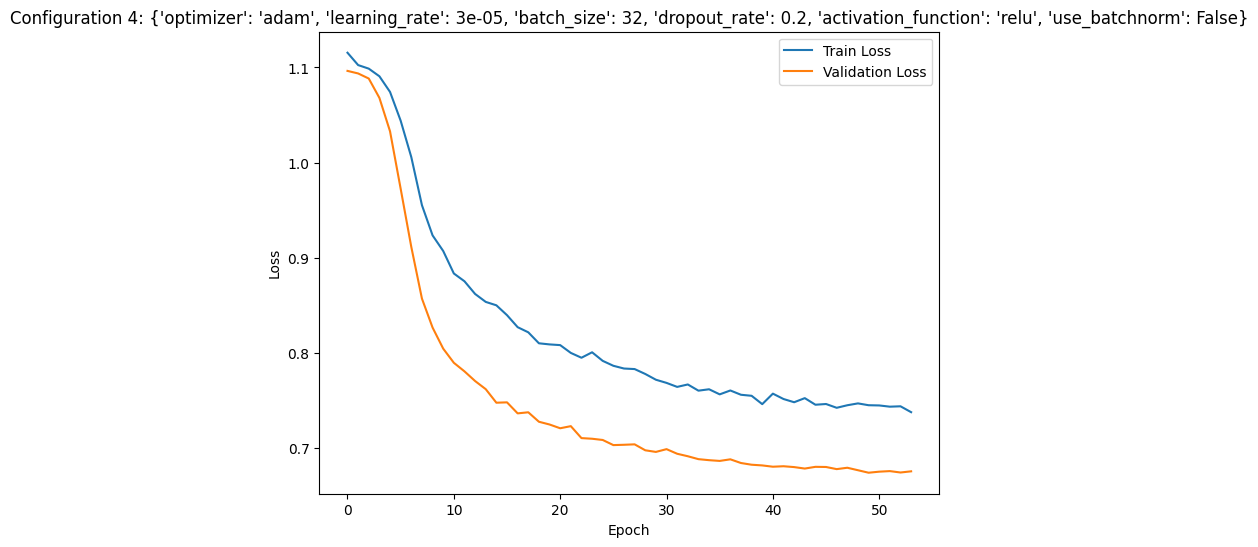

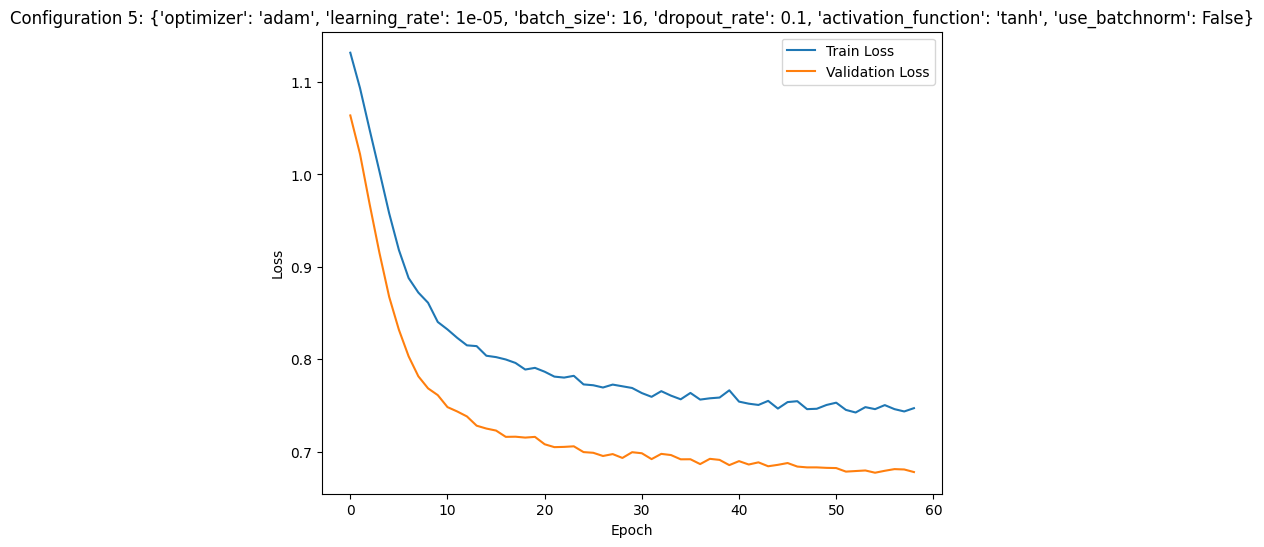

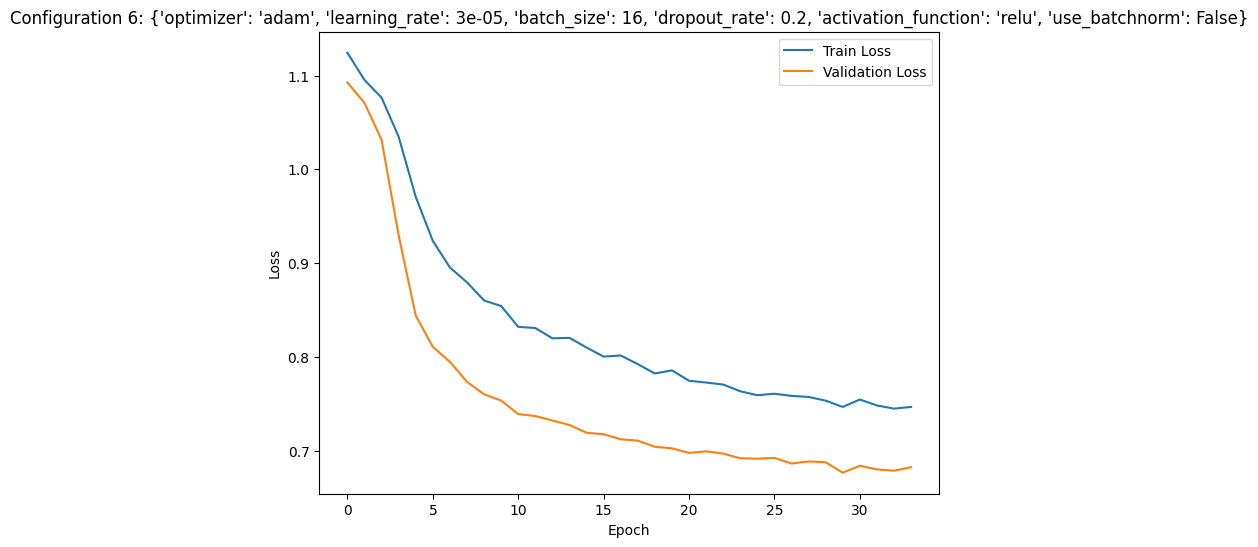

In [ ]:
# Plot training and validation loss for each configuration
for i, (history, config) in enumerate(histories):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Configuration {i+1}: {config}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

##### 6.2.4 Non-Batch-Normalized Models: Model Results

In [ ]:
# Create a DataFrame of the results
results_df = pd.DataFrame([{
    'optimizer': res['config']['optimizer'],
    'learning_rate': res['config']['learning_rate'],
    'batch_size': res['config']['batch_size'],
    'dropout_rate': res['config']['dropout_rate'],
    'activation_function': res['config']['activation_function'],
    'use_batchnorm': res['config']['use_batchnorm'],
    'accuracy': res['accuracy'],
    'loss': res['loss']
} for res in results])

print(results_df)

   optimizer  learning_rate  batch_size  dropout_rate activation_function  \
0      adamw        0.00003          16           0.1                tanh   
1      adamw        0.00003          16           0.1                tanh   
2      adamw        0.00003          32           0.1                tanh   
3      adamw        0.00003          32           0.1                tanh   
4      adamw        0.00001          32           0.1                tanh   
5      adamw        0.00001          32           0.1                tanh   
6       adam        0.00003          32           0.2                relu   
7       adam        0.00003          32           0.2                relu   
8       adam        0.00001          16           0.1                tanh   
9       adam        0.00001          16           0.1                tanh   
10      adam        0.00003          16           0.2                relu   
11      adam        0.00003          16           0.2                relu   

#### 6.3 Frozen Encoder Layers 

##### 6.3.1 Frozen Encoder Layers: Training the Model

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
657/657 [==============================] - 156s 217ms/step - loss: 0.7083 - accuracy: 0.6799 - val_loss: 0.5798 - val_accuracy: 0.7462
Epoch 2/10
657/657 [==============================] - 134s 204ms/step - loss: 0.5649 - accuracy: 0.7679 - val_loss: 0.6187 - val_accuracy: 0.7356
Epoch 3/10
657/657 [==============================] - 134s 204ms/step - loss: 0.4767 - accuracy: 0.8105 - val_loss: 0.6324 - val_accuracy: 0.7493
Epoch 4/10
141/141 [==============================] - 10s 73ms/step - loss: 0.6086 - accuracy: 0.7311
Test accuracy: 0.7311111092567444
141/141 [==============================] - 12s 72ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.69      0.74       773
     Neutral       0.63      0.66      0.64       741
    Positive       0.78      0.85      0.81       736

    accuracy                           0.73      2250
   macro avg       0.73      0.73      0.73      2250
weighted avg       0

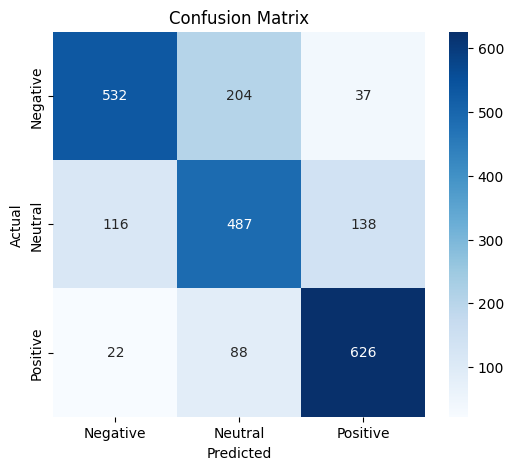

In [ ]:
from transformers import TFRobertaForSequenceClassification

# Load the pre-trained distilroberta model for sequence classification
model = TFRobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=3)

# Freeze the first 3 encoder layers
for layer in model.roberta.encoder.layer[:3]:
    layer.trainable = False

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

# Define the loss with from_logits=True
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

# Set batch size and create datasets
batch_size = 16
train_dataset = create_tf_dataset(train_input_ids, train_attention_mask, train_labels, batch_size)
val_dataset = create_tf_dataset(val_input_ids, val_attention_mask, val_labels, batch_size)
test_dataset = create_tf_dataset(test_input_ids, test_attention_mask, test_labels, batch_size)

# Set up callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model using the validation set
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
)

# Record the history and config
histories.append((history, {'learning_rate': 3e-5, 'batch_size': 16}))

# Evaluate the final model on the test set
loss, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {accuracy}")

# Store results
results.append({
    'learning_rate': 3e-5,
    'batch_size': 16,
    'accuracy': accuracy,
    'loss': loss,
})

# Generate predictions for the test set
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs.logits, axis=1)

# Flatten test labels
y_true = test_labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(f"Classification Report:\n{report}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix')
plt.show()

# Store results
results.append({
    'learning_rate': 3e-5,
    'batch_size': 16,
    'accuracy': accuracy,
    'loss': loss,
    'confusion_matrix': cm,
    'classification_report': report
})

# If current model is better, save it

# Clear previous best model from memory if exists

best_accuracy = accuracy
best_model = model
best_config = {'learning_rate': 3e-5, 'batch_size': 16}
best_y_pred = y_pred
best_y_true = y_true
# Also store confusion matrix and classification report
best_cm = cm
best_report = report

In [ ]:
# Save the tokenizer (recommended)
tokenizer.save_pretrained('model_directory')

# Save the model
model.save_pretrained('model_directory')

##### 6.3.2 Frozen Encoder Layers: Mis-classified Prices

In [ ]:
# After the training loop
print(f"\nBest Model Configuration: {best_config}")
print(f"Best Model Test Accuracy: {best_accuracy}")

# Use the best model's predictions
y_pred = best_y_pred
y_true = best_y_true

# Identify misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]

# Decode test texts
def decode_texts(input_ids):
    return [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

test_texts = decode_texts(test_input_ids)

# Extract false positives and false negatives
false_positives = []
false_negatives = []

# Mapping of label indices to label names
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Loop through misclassified examples to separate false positives and false negatives
for idx in misclassified_indices:
    true_label = y_true[idx]
    predicted_label = y_pred[idx]
    text = test_texts[idx]

    if predicted_label == 2 and true_label != 2:
        # Model predicted Positive, but true label is Negative or Neutral
        false_positives.append((text, label_map[true_label], label_map[predicted_label]))
    elif predicted_label != 2 and true_label == 2:
        # Model predicted Negative or Neutral, but true label is Positive
        false_negatives.append((text, label_map[true_label], label_map[predicted_label]))

# Display a few examples of false positives
print("\nExamples of False Positives:")
for i in range(min(3, len(false_positives))):
    text, true_label, predicted_label = false_positives[i]
    print(f"\nText: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")

# Display a few examples of false negatives
print("\nExamples of False Negatives:")
for i in range(min(3, len(false_negatives))):
    text, true_label, predicted_label = false_negatives[i]
    print(f"\nText: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")


Best Model Configuration: {'learning_rate': 3e-05, 'batch_size': 16}
Best Model Test Accuracy: 0.7311111092567444

Examples of False Positives:

Text: this is quite good ive taken to starting my mornings with a nice hot mug
True Label: Neutral
Predicted Label: Positive

Text: i love gloria jeans cinnamon nut strudel coffee and decided to try this the flavoring is a little over powering for me if youve tried this flavor before and like it you wont be disappointed with it in the kcups packaging
True Label: Neutral
Predicted Label: Positive

Text: im an espresso nut and have several machines that i call my friends one of these is a jura s avantgarde and after trying dozens and dozens of various beans to find the perfect mate intelligentsia black cat classic prevailed as the very clear winner there may be better beans out there but not for this machine ive served thousands of shots of this espresso out of the jura and everyone is impressed by it actually not just impressed blown away its 

##### 6.3.3 Frozen Encoder Layers: Training vs. Validation

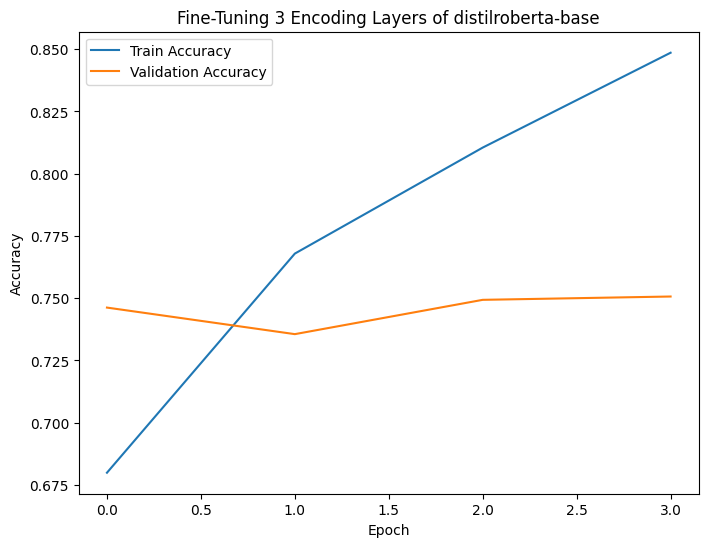

In [ ]:
# Plot training and validation accuracy for each configuration
for i, (history, config) in enumerate(histories):
  if i == 6:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Fine-Tuning 3 Encoding Layers of distilroberta-base")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
  else:
    None

As seen above, this model has the highest test accuracy and as such is our best performing model. This will be the model we use for the inference pipeline.

### 7. Inference Pipeline

Below is the inference pipeline for our model. It is a function that takes text and returns the predicted sentiment. 

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('model_directory')

# Load the model
best_model = TFRobertaForSequenceClassification.from_pretrained('model_directory')

In [ ]:
import re

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('utf-8')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
import tensorflow as tf

def predict_sentiment(text):
    # Clean the input text
    cleaned_text = clean_text(text)

    # Tokenize the text
    inputs = tokenizer(
        cleaned_text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )

    # Get model predictions
    outputs = best_model(inputs)
    logits = outputs.logits

    # Get the predicted class
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]

    # Map the predicted class to sentiment label
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment = sentiment_labels[predicted_class]

    return predicted_sentiment

# Example usage
sample_text = "This product is fantastic! I absolutely love it."
predicted_sentiment = predict_sentiment(sample_text)
print(f"\nText: {sample_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at model_directory.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.



Text: This product is fantastic! I absolutely love it.
Predicted Sentiment: Positive


### 8. Reflections

Andre: Creating these models was very eye opening for me. In particular, I learned a lot about how long it takes in order to properly train models. Along with this, I learned about the importance of the quantity of training data for fine tuning models. Finally, I learned about the importance of saving models having lost 2 models that took upwards of an hour to train each. Having done this project, I am now far more comfortable with google colab and how to train models using GPUs.

Adnan: After preprocessing the data and ensuring that each class had an equal number of samples, I used the pre-trained model "cardiffnlp/twitter-roberta-base-sentiment-latest" and applied the model's tokenizer for tokenization. I used the full set of 127,920 samples, with 42,640 samples for each class: Negative, Neutral, and Positive. I utilized the Trainer and set the following parameters in the TrainingArguments: output directory as "./results", evaluation strategy as "steps", with evaluations and model saves every 450 steps, a reduced batch size of 16 for both training and evaluation, 4 training epochs, a learning rate of 2e-5, weight decay of 0.01, seed set to 42, logging every 50 steps, and mixed precision enabled (fp16). Additionally, gradient accumulation steps were set to 4, simulating a larger batch size, and tensorboard was used for logging. The results I obtained were: for Class 0 (Negative), Precision: 0.85, Recall: 0.84, F1-Score: 0.85; for Class 1 (Neutral), Precision: 0.78, Recall: 0.80, F1-Score: 0.79; and for Class 2 (Positive), Precision: 0.92, Recall: 0.91, F1-Score: 0.92. The overall Precision for each class was [0.8547, 0.7764, 0.9239], Recall was [0.8409, 0.8036, 0.9063], and F1-Score was [0.8478, 0.7898, 0.9151]. I wanted to experiment with changes in batch size, learning rate, and the number of epochs, as well as trying a manual optimizer with grid search. However, the training took 6 hours and 30 minutes, and I lacked the time and resources to implement these changes.

Majed: Training these models taught me the importance of resource management, early in the model training, I ended up using all 100 units over one night to train a model on the entire dataset. Additionally, I learned that brute force is never the answer, while training on the entire dataset might be enticing, we should train on a portion of the dataset until we reach a desirable model with proven potential to perform well using the entire dataset. Lastly, while this work isn't in the final report, it is on the github, I learned how to create a pipeline which can intake raw data, and convert it through multiple steps to a desirable and usable output.

Yonotan: In my recent work, I gained valuable insights into the use of LSTM models for sentiment analysis, particularly in handling sequential data like product reviews. Implementing GloVe embeddings enhanced my understanding of pre-trained word embeddings and their role in improving model performance while reducing training time. I also tackled the challenge of data imbalance, learning the importance of addressing skewed label distributions to avoid biased models. Through model evaluation, I observed the differences in accuracy between validation and testing datasets, emphasizing the need for robust evaluation to ensure generalizability. Moving forward, I aim to focus on tuning hyperparameters such as learning rates, dropout rates, and epochs to further optimize performance. Additionally, a deeper analysis of misclassified instances will provide valuable insights into areas where the model struggles, allowing for targeted improvements.

Younes: We applied the pre-trained model from hugging face roBERTa, version “roberta-base”. We reduced the data as we have limited GPU resources. 
Description of hyperparameters:
Batch size = 16
Max length Tokenization = 128 
Learning_rate=1e-6
Optimizer= Adam
Loss function = Sparse Categorical Cross-entropy
Number of epochs = 10

We performed 3 trainings: 
-First training with 3000 samples resulted in underfitting, (Test loss: 58.82% - Test Accuracy: 76%) 
-Second training with 30000 samples resulted in overfitting, (Test loss: 56.45% - Test Accuracy: 76.32%)
-Third training with 30000 samples resulted in overfitting too, but a slight improvement (Test loss: 55.26% - Test Accuracy: 77.23%)

To improve, we can tune the hyperparameters by increasing the size of batches or adding more epochs. We can also try transfer learning by freezing the first layers, and see how the model can behave by training the last layers. We can also try other learning rates.